## General information

Just Andrew's Data Munging plus a quick Genetic Programming Model

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge

In [2]:
%%time
train = pd.read_csv('data/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 2min 37s, sys: 5.9 s, total: 2min 43s
Wall time: 2min 45s


In [3]:
train.shape

(629145480, 2)

In [4]:
# train_acoustic_data_small = train['acoustic_data'].values[::50]
# train_time_to_failure_small = train['time_to_failure'].values[::50]

# fig, ax1 = plt.subplots(figsize=(16, 8))
# plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
# plt.plot(train_acoustic_data_small, color='b')
# ax1.set_ylabel('acoustic_data', color='b')
# plt.legend(['acoustic_data'])
# ax2 = ax1.twinx()
# plt.plot(train_time_to_failure_small, color='g')
# ax2.set_ylabel('time_to_failure', color='g')
# plt.legend(['time_to_failure'], loc=(0.875, 0.9))
# plt.grid(False)

# del train_acoustic_data_small
# del train_time_to_failure_small

In [5]:
# Create a training file with simple derived features
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)

y_tr = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

total_mean = train['acoustic_data'].mean()
total_std = train['acoustic_data'].std()
total_max = train['acoustic_data'].max()
total_min = train['acoustic_data'].min()
total_sum = train['acoustic_data'].sum()
total_abs_sum = np.abs(train['acoustic_data']).sum()

for segment in tqdm_notebook(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = pd.Series(seg['acoustic_data'].values)
    y = seg['time_to_failure'].values[-1]
    
    y_tr.loc[segment, 'time_to_failure'] = y
    X_tr.loc[segment, 'mean'] = x.mean()
    X_tr.loc[segment, 'std'] = x.std()
    X_tr.loc[segment, 'max'] = x.max()
    X_tr.loc[segment, 'min'] = x.min()
    
    
    X_tr.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
    X_tr.loc[segment, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    X_tr.loc[segment, 'abs_max'] = np.abs(x).max()
    X_tr.loc[segment, 'abs_min'] = np.abs(x).min()
    
    X_tr.loc[segment, 'std_first_50000'] = x[:50000].std()
    X_tr.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X_tr.loc[segment, 'std_first_10000'] = x[:10000].std()
    X_tr.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    X_tr.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    X_tr.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X_tr.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    X_tr.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    X_tr.loc[segment, 'min_first_50000'] = x[:50000].min()
    X_tr.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X_tr.loc[segment, 'min_first_10000'] = x[:10000].min()
    X_tr.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    X_tr.loc[segment, 'max_first_50000'] = x[:50000].max()
    X_tr.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X_tr.loc[segment, 'max_first_10000'] = x[:10000].max()
    X_tr.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
    X_tr.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X_tr.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_tr.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    X_tr.loc[segment, 'sum'] = x.sum()
    
    X_tr.loc[segment, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(x[:50000]) / x[:50000][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(x[-50000:]) / x[-50000:][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(x[:10000]) / x[:10000][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(x[-10000:]) / x[-10000:][:-1]))[0])
    
    X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)
    
    X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_tr.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_tr.loc[segment, 'trend'] = add_trend_feature(x)
    X_tr.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_tr.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_tr.loc[segment, 'abs_std'] = np.abs(x).std()
    
    X_tr.loc[segment, 'mad'] = x.mad()
    X_tr.loc[segment, 'kurt'] = x.kurtosis()
    X_tr.loc[segment, 'skew'] = x.skew()
    X_tr.loc[segment, 'med'] = x.median()
    
    X_tr.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_tr.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_tr.loc[segment, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_tr.loc[segment, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_tr.loc[segment, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_tr.loc[segment, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_tr.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    X_tr.loc[segment, 'Moving_average_1500_mean'] = x.rolling(window=1500).mean().mean(skipna=True)
    X_tr.loc[segment, 'Moving_average_3000_mean'] = x.rolling(window=3000).mean().mean(skipna=True)
    X_tr.loc[segment, 'Moving_average_6000_mean'] = x.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_tr.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X_tr.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_tr.loc[segment,'MA_700MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment,'MA_700MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_tr.loc[segment,'MA_400MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment,'MA_400MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    
    X_tr.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_tr.loc[segment, 'q999'] = np.quantile(x,0.999)
    X_tr.loc[segment, 'q001'] = np.quantile(x,0.001)
    X_tr.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_tr.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_tr.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_tr.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_tr.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_tr.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_tr.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_tr.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_tr.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_tr.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_tr.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_tr.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_tr.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_tr.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_tr.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_tr.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_tr.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_tr.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_tr.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [6]:
X_tr.to_csv('4194data.csv', index=False)

In [7]:
X_tr.head(10)

,mean,std,max,min,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,4.884113333333334,5.101106130606765,104.0,-98.0,-0.000080000533337,74836.577199220613693,104.0,0.0,6.488551888989741,3.664663420228340,...,0.295714650592636,5.629,3.896,4.072,4.379,5.338,5.484,-0.000001704697987,74222.343442640820285,5.629
1,4.725766666666667,6.588823781946801,181.0,-154.0,0.000000000000000,74891.736231905975728,181.0,0.0,7.305232697765033,5.493070500263983,...,0.231586699576737,5.667,3.412,4.233,4.345,5.066,5.223,-0.000002449664430,74364.426477527638781,5.667
2,4.906393333333333,6.967397033524431,140.0,-106.0,-0.000013333422223,75099.224450501744286,140.0,0.0,6.104836457315087,8.603695613814120,...,0.267011771793293,5.957,4.055,4.239,4.446,5.344,5.486,0.000001140939597,74594.984584474615986,5.957
3,4.902240000000000,6.922305187180113,197.0,-199.0,0.000000000000000,74933.991878648565034,199.0,0.0,6.238109475682244,5.652441899780007,...,0.266699817775971,5.858,3.722,4.304,4.433,5.317,5.453,-0.000002550335570,74333.143622613599291,5.858
4,4.908720000000000,7.301110189758817,145.0,-126.0,-0.000006666711111,75010.016045975266024,145.0,0.0,5.323829516204886,7.694506067635043,...,0.228004751350508,6.078,3.918,4.434,4.543,5.306,5.491,0.000001550335570,74428.435968884237809,6.078
5,4.913513333333333,5.434111112860393,142.0,-144.0,-0.000073333822225,75045.710252893069992,144.0,0.0,4.442139669539542,5.145255323756726,...,0.293941260517808,5.838,4.042,4.270,4.422,5.402,5.620,-0.000003697986577,74539.909434154062183,5.838
6,4.855660000000000,5.687823395051908,120.0,-78.0,0.000033333555557,75084.513678133123904,120.0,0.0,5.944367789914116,5.386871728576837,...,0.219471906215868,5.546,3.958,4.285,4.504,5.214,5.370,-0.000000114093960,74501.904750525020063,5.546
7,4.505426666666667,5.854511569720713,139.0,-134.0,0.000000000000000,75066.009998334877309,139.0,0.0,6.069745905942625,7.078177045214797,...,0.218514054888406,5.180,3.489,4.040,4.148,4.863,4.953,-0.000001395973154,74515.926219409957412,5.180
8,4.717833333333333,7.789643113079984,168.0,-156.0,0.000013333422223,74992.566175417436170,168.0,0.0,9.288044073197225,5.993101599083361,...,0.240916531351268,5.717,3.933,4.158,4.315,5.104,5.337,0.000002221476510,74464.251034999178955,5.717
9,4.730960000000000,6.890459152667711,152.0,-126.0,-0.000006666711111,74902.631244055970456,152.0,0.0,9.012694753720137,4.944025220213542,...,0.258462298074467,5.423,3.832,4.190,4.301,5.128,5.261,0.000005127516779,74344.216474791013752,5.423


In [8]:
print(f'{X_tr.shape[0]} samples in new train data and {X_tr.shape[1]} columns.')

4194 samples in new train data and 138 columns.


In [9]:
np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(12)

q05_roll_std_100     0.648824447085559
q01_roll_std_100     0.644797095592989
q05_roll_std_10      0.643123220257531
q01_roll_std_10      0.635263713488480
q05_roll_std_1000    0.614482273757696
q01_roll_std_1000    0.603691188925208
min_roll_std_1000    0.544294240126950
iqr                  0.506994140262580
q95_roll_std_10      0.439754146578064
q95_roll_mean_10     0.439483461929961
q95_roll_std_100     0.433791697887343
q05_roll_mean_10     0.428967215266466
dtype: float64

In [11]:
# plt.figure(figsize=(44, 24))
# cols = list(np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(24).index)
# for i, col in enumerate(cols):
#     plt.subplot(6, 4, i + 1)
#     plt.plot(X_tr[col], color='blue')
#     plt.title(col)
#     ax1.set_ylabel(col, color='b')

#     ax2 = ax1.twinx()
#     plt.plot(y_tr, color='g')
#     ax2.set_ylabel('time_to_failure', color='g')
#     plt.legend([col, 'time_to_failure'], loc=(0.875, 0.9))
#     plt.grid(False)

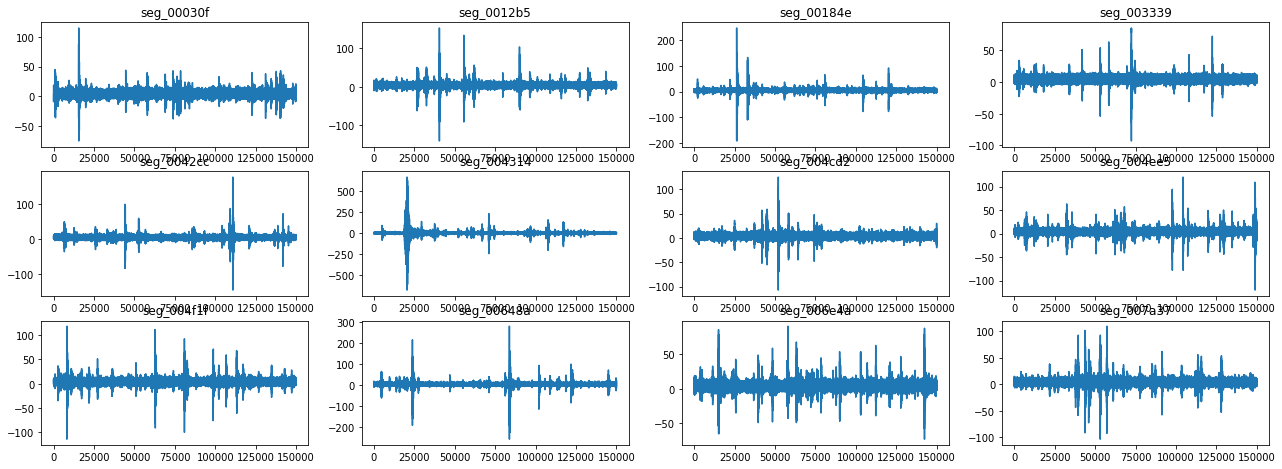

In [12]:
submission = pd.read_csv('data/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)
plt.figure(figsize=(22, 16))

for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv('data/test/' + seg_id + '.csv')
    
    x = pd.Series(seg['acoustic_data'].values)
    X_test.loc[seg_id, 'mean'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
        
    X_test.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(x))
    X_test.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    X_test.loc[seg_id, 'abs_max'] = np.abs(x).max()
    X_test.loc[seg_id, 'abs_min'] = np.abs(x).min()
    
    X_test.loc[seg_id, 'std_first_50000'] = x[:50000].std()
    X_test.loc[seg_id, 'std_last_50000'] = x[-50000:].std()
    X_test.loc[seg_id, 'std_first_10000'] = x[:10000].std()
    X_test.loc[seg_id, 'std_last_10000'] = x[-10000:].std()
    
    X_test.loc[seg_id, 'avg_first_50000'] = x[:50000].mean()
    X_test.loc[seg_id, 'avg_last_50000'] = x[-50000:].mean()
    X_test.loc[seg_id, 'avg_first_10000'] = x[:10000].mean()
    X_test.loc[seg_id, 'avg_last_10000'] = x[-10000:].mean()
    
    X_test.loc[seg_id, 'min_first_50000'] = x[:50000].min()
    X_test.loc[seg_id, 'min_last_50000'] = x[-50000:].min()
    X_test.loc[seg_id, 'min_first_10000'] = x[:10000].min()
    X_test.loc[seg_id, 'min_last_10000'] = x[-10000:].min()
    
    X_test.loc[seg_id, 'max_first_50000'] = x[:50000].max()
    X_test.loc[seg_id, 'max_last_50000'] = x[-50000:].max()
    X_test.loc[seg_id, 'max_first_10000'] = x[:10000].max()
    X_test.loc[seg_id, 'max_last_10000'] = x[-10000:].max()
    
    X_test.loc[seg_id, 'max_to_min'] = x.max() / np.abs(x.min())
    X_test.loc[seg_id, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_test.loc[seg_id, 'count_big'] = len(x[np.abs(x) > 500])
    X_test.loc[seg_id, 'sum'] = x.sum()
    
    X_test.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(x[:50000]) / x[:50000][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(x[-50000:]) / x[-50000:][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(x[:10000]) / x[:10000][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(x[-10000:]) / x[-10000:][:-1]))[0])
    
    X_test.loc[seg_id, 'q95'] = np.quantile(x,0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(x,0.99)
    X_test.loc[seg_id, 'q05'] = np.quantile(x,0.05)
    X_test.loc[seg_id, 'q01'] = np.quantile(x,0.01)
    
    X_test.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_test.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_test.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_test.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_test.loc[seg_id, 'trend'] = add_trend_feature(x)
    X_test.loc[seg_id, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x).std()
    
    X_test.loc[seg_id, 'mad'] = x.mad()
    X_test.loc[seg_id, 'kurt'] = x.kurtosis()
    X_test.loc[seg_id, 'skew'] = x.skew()
    X_test.loc[seg_id, 'med'] = x.median()
    
    X_test.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_test.loc[seg_id, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_test.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_test.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_test.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_test.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_test.loc[seg_id, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_1500_mean'] = x.rolling(window=1500).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_3000_mean'] = x.rolling(window=3000).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_6000_mean'] = x.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_test.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(x, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X_test.loc[seg_id, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_test.loc[seg_id,'MA_700MA_BB_high_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X_test.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X_test.loc[seg_id,'MA_700MA_BB_low_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X_test.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X_test.loc[seg_id, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_test.loc[seg_id,'MA_400MA_BB_high_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X_test.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X_test.loc[seg_id,'MA_400MA_BB_low_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X_test.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X_test.loc[seg_id, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    
    X_test.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_test.loc[seg_id, 'q999'] = np.quantile(x,0.999)
    X_test.loc[seg_id, 'q001'] = np.quantile(x,0.001)
    X_test.loc[seg_id, 'ave10'] = stats.trim_mean(x, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_test.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_test.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_test.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_test.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_test.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_test.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_test.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_test.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_test.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_test.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_test.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_test.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
    
    if i < 12:
        plt.subplot(6, 4, i + 1)
        plt.plot(seg['acoustic_data'])
        plt.title(seg_id)
    


In [13]:
def GPI(data):
    return (5.591662 +
            0.0399999991*np.tanh(((data["mean_change_rate_first_10000"]) - (((73.0) * ((((((7.0) * (((((((((data["q95"]) + (((0.3183098733) + (data["q05_roll_std_100"]))))) * 2.0)) * 2.0)) + (((data["q95_roll_std_10"]) + (data["iqr"]))))))) + (data["iqr"]))/2.0)))))) +
            0.0399999991*np.tanh(((((3.6923100948) + (data["Moving_average_6000_mean"]))) * (((73.0) * (((data["MA_400MA_BB_low_mean"]) - (((((data["Moving_average_6000_mean"]) * (data["q05_roll_std_10"]))) + (((data["iqr"]) + (((data["q05_roll_std_10"]) * (((3.6923100948) * 2.0)))))))))))))) +
            0.0399999991*np.tanh(((((((((((((((((((((((data["q05"]) * 2.0)) * 2.0)) - (data["iqr"]))) - (data["max_roll_std_1000"]))) * 2.0)) * 2.0)) * 2.0)) - (data["iqr"]))) - (3.6923100948))) - (((data["q05_roll_std_10"]) * (73.0))))) * 2.0)) +
            0.0399999991*np.tanh(((((((((((((((((((data["q05_roll_std_10"]) * (((((-3.0) * 2.0)) * 2.0)))) - (((data["iqr"]) + (data["max_roll_std_1000"]))))) * 2.0)) * 2.0)) * 2.0)) - (data["max_roll_mean_100"]))) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((73.0) * ((((data["max_first_50000"]) + ((((data["max_first_50000"]) + (((73.0) * (((data["q05"]) - (((data["q05_roll_std_100"]) + (((0.5555559993) + (((data["mad"]) + (data["q95"]))))))))))))/2.0)))/2.0)))) +
            0.0399999991*np.tanh(((((((data["q05_roll_std_10"]) * (73.0))) * 2.0)) - ((((((((data["q05_roll_std_10"]) * (73.0))) + (((((((((data["iqr"]) + (((data["MA_1000MA_std_mean"]) + (data["abs_max_roll_mean_10"]))))) * 2.0)) * 2.0)) * 2.0)))/2.0)) * (73.0))))) +
            0.0399999991*np.tanh(((((data["mean_change_abs"]) - (((((data["q95"]) + (((data["q95"]) + (((((data["q05_roll_std_100"]) / 2.0)) + (((((((0.3183098733) * 2.0)) - (data["q05"]))) - (data["q05"]))))))))) * (73.0))))) * 2.0)) +
            0.0399999991*np.tanh((-1.0*(((((((7.48210620880126953)) * 2.0)) + (((((data["iqr"]) + ((((-1.0*((data["avg_first_10000"])))) * 2.0)))) + (((73.0) * (((data["iqr"]) + (((((data["q05_roll_std_10"]) * 2.0)) * 2.0))))))))))))) +
            0.0399999991*np.tanh((((((data["q01_roll_std_10"]) + (((((data["q05_roll_mean_10"]) - (((((data["q05_roll_std_100"]) - (((data["q05"]) - (0.3026320040))))) + (((((((0.5434780121) + (0.3026320040))/2.0)) + (data["iqr"]))/2.0)))))) * (73.0))))/2.0)) * (73.0))) +
            0.0399999991*np.tanh(((((data["trend"]) + (((data["q95_roll_std_10"]) + (data["trend"]))))) - (((73.0) * (((((((data["ave_roll_std_10"]) + (((((((data["q95_roll_mean_10"]) + (data["q05_roll_std_1000"]))/2.0)) + (data["q05_roll_std_1000"]))/2.0)))/2.0)) + ((((0.5434780121) + (data["q95_roll_mean_10"]))/2.0)))/2.0)))))) +
            0.0399999991*np.tanh(((73.0) - (((((73.0) * 2.0)) * (((73.0) * ((((((((((data["q05_roll_std_1000"]) / 2.0)) + (data["iqr"]))/2.0)) + (data["q05_roll_std_10"]))) + (((0.2183910012) + (data["q95"]))))))))))) +
            0.0399999991*np.tanh(((73.0) * (((73.0) * (((((73.0) * (((data["q05_roll_mean_10"]) - (((((data["q05_roll_std_100"]) + (data["q95"]))) + (0.5434780121))))))) + (data["q05_roll_std_100"]))))))) +
            0.0399999991*np.tanh((-1.0*((((73.0) * (((73.0) * (((73.0) * (((data["q05_roll_std_100"]) + ((((data["q95_roll_mean_10"]) + ((((data["Moving_average_3000_mean"]) + (((((data["iqr"]) + (0.9756100178))) + (data["abs_mean"]))))/2.0)))/2.0))))))))))))) +
            0.0399999991*np.tanh(((73.0) * (((((data["classic_sta_lta3_mean"]) + (data["mad"]))) + (((((((73.0) * (((data["q05_roll_mean_10"]) - (((data["q05_roll_std_100"]) + (((data["mad"]) + (0.5555559993))))))))) - (data["iqr"]))) - (data["iqr"]))))))) +
            0.0399999991*np.tanh(((((np.tanh((data["q95_roll_std_10"]))) + (((((((data["q05_roll_std_10"]) + ((((((0.2439019978) + (data["ave10"]))/2.0)) / 2.0)))) * 2.0)) * 2.0)))) * (((data["q05_roll_std_10"]) - (((73.0) * (((73.0) * (73.0))))))))) +
            0.0399999991*np.tanh(((3.6923100948) * (((73.0) * (((3.6923100948) * ((((((-1.0*((data["q99_roll_mean_1000"])))) * (data["avg_last_50000"]))) - (((data["q05_roll_std_10"]) * (((3.6923100948) + (((3.6923100948) + (data["abs_max_roll_mean_100"]))))))))))))))) +
            0.0399999991*np.tanh(((((((data["Moving_average_1500_mean"]) + (((((((((data["MA_400MA_BB_low_mean"]) + ((((-1.0*((data["q05_roll_std_1000"])))) - (data["iqr"]))))) * (73.0))) - (data["min_roll_std_1000"]))) - (data["q05_roll_std_1000"]))))) * (73.0))) * (73.0))) +
            0.0399999991*np.tanh(((73.0) - (((73.0) * (((73.0) * (((data["q05_roll_std_10"]) + (np.tanh(((((((data["exp_Moving_average_3000_mean"]) + (((data["iqr"]) + (np.tanh((((data["q05_roll_std_100"]) + (data["exp_Moving_average_30000_mean"]))))))))/2.0)) / 2.0)))))))))))) +
            0.0399999991*np.tanh(((73.0) * (((73.0) * (((data["q05_roll_mean_10"]) - (((np.tanh((np.tanh((np.tanh((np.tanh((np.tanh((data["q05_roll_std_100"]))))))))))) + ((((data["q95_roll_std_10"]) + (np.tanh((2.8437500000))))/2.0)))))))))) +
            0.0399999991*np.tanh(((((((data["iqr"]) / 2.0)) + (((data["mean"]) + (((data["q05_roll_std_100"]) + (((data["q05_roll_std_10"]) * 2.0)))))))) * ((-1.0*((((73.0) - (((((((((data["mean"]) * 2.0)) * 2.0)) * 2.0)) * 2.0))))))))) +
            0.0399999991*np.tanh(((((((((0.5217390060) - (((((data["q05_roll_std_10"]) * ((-1.0*((7.0)))))) + (data["exp_Moving_average_3000_mean"]))))) * ((-1.0*((73.0)))))) - (((data["classic_sta_lta4_mean"]) * (7.0))))) - ((((7.0) + (data["classic_sta_lta4_mean"]))/2.0)))) +
            0.0399999991*np.tanh(((((((((((((((((((np.tanh(((-1.0*((((data["q05_roll_mean_100"]) + (0.2183910012)))))))) - ((((data["q05_roll_std_100"]) + (((data["q05_roll_std_10"]) * 2.0)))/2.0)))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) - (data["exp_Moving_average_30000_mean"]))) * 2.0)) +
            0.0399999991*np.tanh(((data["trend"]) - (((73.0) * ((((3.6923100948) + ((((9.0)) * (((np.tanh((np.tanh((np.tanh((np.tanh((np.tanh((np.tanh((np.tanh((data["q05_roll_std_100"]))))))))))))))) - (data["q05_roll_mean_10"]))))))/2.0)))))) +
            0.0399999991*np.tanh(((data["q05_roll_std_1000"]) - (((73.0) * (((data["avg_last_50000"]) + (((((73.0) * 2.0)) * (((data["ave_roll_std_100"]) + (((data["Moving_average_6000_mean"]) + (((data["iqr"]) + (((data["q05_roll_std_1000"]) + (((data["q95"]) * 2.0)))))))))))))))))) +
            0.0399999991*np.tanh(((((data["q05_roll_mean_10"]) - (2.0769200325))) - ((((((6.08570814132690430)) * (((2.0769200325) + (((((((((data["q05_roll_std_10"]) - (data["q05_roll_mean_10"]))) * 2.0)) * 2.0)) * 2.0)))))) + (((((data["av_change_rate_roll_std_100"]) - (data["avg_last_10000"]))) * 2.0)))))) +
            0.0399999991*np.tanh((-1.0*((((((((((((((((((((((((((((((((data["q05_roll_std_1000"]) + (data["q05_roll_mean_100"]))/2.0)) * 2.0)) + (data["iqr"]))/2.0)) + (data["q95_roll_mean_10"]))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0))))) +
            0.0399999991*np.tanh((((-1.0*((((((((((data["q05_roll_std_100"]) - (np.tanh(((-1.0*((((data["MA_400MA_std_mean"]) + (((data["exp_Moving_average_300_mean"]) * (((data["q05_roll_std_100"]) * 2.0))))))))))))) * 2.0)) * 2.0)) + (np.tanh((data["q05_roll_std_100"])))))))) * (73.0))) +
            0.0399999991*np.tanh(((((data["abs_q05"]) - ((((((2.0769200325) * ((((((73.0) * ((((((0.5555559993) + (((data["q05_roll_std_100"]) + (0.7446810007))))/2.0)) + (data["q05_roll_std_100"]))))) + (0.5555559993))/2.0)))) + (0.5555559993))/2.0)))) * 2.0)) +
            0.0399999991*np.tanh((((10.75933361053466797)) - (((7.0) * (((7.0) * (((7.0) * ((((((data["q95_roll_mean_10"]) + (data["q05_roll_std_100"]))) + ((((data["q95_roll_mean_10"]) + (((data["iqr"]) + (((data["Moving_average_700_mean"]) * 2.0)))))/2.0)))/2.0)))))))))) +
            0.0399999991*np.tanh(((73.0) * (((((data["q05_roll_std_1000"]) + ((((data["q05_roll_std_10"]) + ((((((data["q05_roll_std_1000"]) + (np.tanh((data["q05_roll_std_1000"]))))/2.0)) - (((data["q95_roll_mean_1000"]) - (np.tanh((73.0))))))))/2.0)))) * (((2.8437500000) - (73.0))))))) +
            0.0399999991*np.tanh(((((((((-3.0) + (data["Moving_average_3000_mean"]))) - (((73.0) * (((data["ave_roll_mean_10"]) - ((((((data["q05_roll_std_100"]) + (data["q95_roll_mean_10"]))/2.0)) * (((-3.0) - (((data["Moving_average_700_mean"]) + (data["q95_roll_mean_10"]))))))))))))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((data["classic_sta_lta3_mean"]) * 2.0)) + (data["q05_roll_mean_100"]))) - (((73.0) * (((((((0.6582279801) + (data["q05_roll_std_10"]))) - (((data["q05_roll_mean_10"]) * 2.0)))) + ((((-1.0*((data["abs_q05"])))) + (((data["q05_roll_std_100"]) * 2.0)))))))))) +
            0.0399999991*np.tanh(((((data["skew"]) + (((data["kurt"]) + (data["med"]))))) - ((((7.02540111541748047)) * (((((data["iqr"]) + (((data["q95_roll_std_10"]) + (((((data["q95_roll_mean_10"]) + (((data["iqr"]) * (data["Moving_average_1500_mean"]))))) * 2.0)))))) * 2.0)))))) +
            0.0399999991*np.tanh(((((data["q05_roll_std_100"]) - (((-2.0) + (((((data["iqr"]) * (-2.0))) - ((-1.0*((data["av_change_rate_roll_std_10"])))))))))) - ((((((data["q05_roll_std_100"]) + (np.tanh((((data["q05_roll_std_100"]) * (data["ave_roll_mean_10"]))))))/2.0)) * (73.0))))) +
            0.0399999991*np.tanh(((((((((((data["q05_roll_std_10"]) + (((data["av_change_abs_roll_std_1000"]) - (((data["av_change_abs_roll_mean_10"]) * 2.0)))))) * 2.0)) + (data["av_change_abs_roll_std_1000"]))) * 2.0)) - (((73.0) * (((((data["abs_max_roll_mean_1000"]) + (((0.5555559993) + (data["q05_roll_std_10"]))))) * 2.0)))))) +
            0.0399999991*np.tanh((((((((((((((((((np.tanh((((((data["q95_roll_mean_10"]) + (data["q95_roll_std_100"]))) - (data["q05_roll_std_1000"]))))) + (data["q95_roll_std_100"]))/2.0)) + (data["q95_roll_std_100"]))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) - (((73.0) * (data["q95_roll_mean_10"]))))) * 2.0)) +
            0.0399999991*np.tanh(((73.0) - (((((((((((data["q05_roll_std_10"]) * 2.0)) - (data["ave10"]))) + (((data["q05_roll_std_100"]) + (0.9756100178))))) * (73.0))) * (((73.0) * 2.0)))))) +
            0.0399999991*np.tanh(((((data["Moving_average_6000_mean"]) + (((7.0) + (((data["ave10"]) * 2.0)))))) * (((((((((data["MA_700MA_BB_low_mean"]) * (data["avg_last_50000"]))) + ((-1.0*((((data["q95_roll_mean_10"]) * 2.0))))))) - (((data["ave_roll_mean_10"]) + (data["q05_roll_std_100"]))))) * 2.0)))) +
            0.0399999991*np.tanh(((73.0) * (((data["q05_roll_std_100"]) - (((((((data["iqr"]) - (np.tanh((((73.0) * (((data["ave10"]) - (((data["iqr"]) + (((((data["q05_roll_std_1000"]) + (0.5434780121))) * 2.0)))))))))))) * 2.0)) * 2.0)))))) +
            0.0399999991*np.tanh(((((((((((((((data["exp_Moving_average_30000_mean"]) * (((data["exp_Moving_average_30000_mean"]) + ((-1.0*((data["q01_roll_std_10"])))))))) - (((data["q05_roll_std_10"]) + (((data["q05_roll_std_10"]) + (((data["q95_roll_mean_100"]) + (data["q05_roll_std_10"]))))))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((73.0) - (((((data["q05_roll_std_100"]) * (73.0))) * (((73.0) * (((data["q05_roll_std_100"]) * (((data["q05_roll_std_100"]) - (((data["q05"]) - ((((0.2525250018) + (2.0))/2.0)))))))))))))) +
            0.0399999991*np.tanh(((((((((7.0) - ((((data["sum"]) + (((73.0) * (((((data["sum"]) + (data["q05_roll_std_10"]))) + (((((((np.tanh((data["abs_q05"]))) + (data["q05_roll_std_10"]))) * 2.0)) * 2.0)))))))/2.0)))) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((((((1.0)) - (((((((((data["q05_roll_std_100"]) + (np.tanh((((data["abs_q05"]) * (((((data["exp_Moving_average_30000_mean"]) - (data["abs_q05"]))) + (((data["q05_roll_std_100"]) + (((data["q95_roll_mean_10"]) * 2.0)))))))))))) * 2.0)) * 2.0)) * 2.0)))) * 2.0)) +
            0.0399999991*np.tanh(((((np.tanh((((np.tanh((data["Moving_average_1500_mean"]))) * 2.0)))) - (((data["Moving_average_1500_mean"]) + ((-1.0*((((((data["q05_roll_std_100"]) + (np.tanh((0.6582279801))))) * 2.0))))))))) * ((((-1.0*((((data["Moving_average_1500_mean"]) * 2.0))))) - (73.0))))) +
            0.0399999991*np.tanh(((73.0) - ((((((((((((data["q05_roll_std_100"]) + (((data["q05_roll_std_100"]) * (data["Moving_average_6000_mean"]))))/2.0)) + (((data["Moving_average_6000_mean"]) + (((data["q05_roll_std_100"]) + (data["q95"]))))))) * 2.0)) * 2.0)) * (((73.0) + (data["Moving_average_6000_mean"]))))))) +
            0.0399999991*np.tanh(((((((((((((data["mean_change_rate_last_10000"]) - (data["mean_change_abs"]))) - (((((((((((((data["q05_roll_std_10"]) + (((0.5434780121) - (data["q05"]))))) * 2.0)) - (data["Hann_window_mean"]))) * 2.0)) * 2.0)) * 2.0)))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((-1.0*((((data["avg_last_50000"]) * (3.6923100948)))))) + (((73.0) / 2.0)))/2.0)) - (((73.0) * ((((((data["Moving_average_6000_mean"]) + (((data["q05_roll_std_10"]) - (((data["exp_Moving_average_30000_mean"]) * (data["exp_Moving_average_30000_mean"]))))))/2.0)) + (data["q05_roll_std_10"]))))))) +
            0.0399999991*np.tanh(((73.0) * ((-1.0*((((data["q01_roll_std_1000"]) + (((73.0) * (((data["q05_roll_std_100"]) + ((((1.4411799908) + ((((((data["q01_roll_std_1000"]) - (data["q99_roll_mean_1000"]))) + (((data["q99_roll_mean_1000"]) * (data["q99_roll_mean_1000"]))))/2.0)))/2.0))))))))))))) +
            0.0399999991*np.tanh((((12.50784111022949219)) + ((((12.50784111022949219)) - ((((((np.tanh((((data["q05_roll_std_10"]) * (data["q95_roll_mean_1000"]))))) + (((((((data["q05_roll_std_10"]) + (np.tanh((((data["q05_roll_std_10"]) * (data["exp_Moving_average_30000_mean"]))))))) * 2.0)) * 2.0)))/2.0)) * (73.0))))))) +
            0.0399999991*np.tanh(((((((data["skew"]) - (((data["ave_roll_mean_100"]) + (((((((data["ave_roll_mean_100"]) * (data["abs_q05"]))) + (((((2.0) + (((((data["q05_roll_std_100"]) - (data["q05_roll_mean_10"]))) * 2.0)))) * 2.0)))) * 2.0)))))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((data["q95_roll_mean_1000"]) * (data["ave_roll_mean_100"]))) * 2.0)) - (((((data["exp_Moving_average_30000_mean"]) + (((((((((data["exp_Moving_average_30000_mean"]) * (data["q05_roll_std_10"]))) + (((((data["q05_roll_std_10"]) - (0.2439019978))) * 2.0)))) * 2.0)) * 2.0)))) * 2.0)))) * 2.0)) +
            0.0399999991*np.tanh(((((((((data["q05_roll_std_10"]) - (((((data["q95"]) - (((((data["iqr"]) - (((data["exp_Moving_average_3000_mean"]) * (np.tanh((((data["q05_roll_std_10"]) * 2.0)))))))) - (((data["q05_roll_std_10"]) * 2.0)))))) * 2.0)))) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((data["q95_roll_mean_100"]) + (((data["mean_change_rate_first_10000"]) + (((data["abs_q05"]) + (data["abs_q05"]))))))) * (3.6923100948))) + (((((((((data["q05_roll_std_1000"]) + (0.7446810007))) * (((3.6923100948) - (73.0))))) * 2.0)) * 2.0)))) +
            0.0399999991*np.tanh((-1.0*((((((73.0) * ((((((data["q01_roll_mean_1000"]) - (((data["q05"]) * 2.0)))) + (((data["q05_roll_std_1000"]) + (((((data["q05_roll_std_100"]) - (data["q95_roll_mean_1000"]))) * (data["Moving_average_700_mean"]))))))/2.0)))) + (((((data["Moving_average_1500_mean"]) * 2.0)) * 2.0))))))) +
            0.0399999991*np.tanh(((((((((data["q05"]) - (((73.0) * ((((-1.0*((((data["q05"]) * 2.0))))) + (((data["q05_roll_std_1000"]) + (1.9019600153))))))))) + (((((((data["q05"]) + (data["max_to_min"]))) * 2.0)) * 2.0)))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((data["av_change_abs_roll_mean_100"]) - (((data["q01_roll_mean_1000"]) * 2.0)))) - (((73.0) * (((((((data["Hann_window_mean"]) * (((data["q95"]) - (data["q95_roll_mean_1000"]))))) / 2.0)) + (((((data["q95"]) * 2.0)) + (data["q01_roll_mean_1000"]))))))))) * 2.0)) +
            0.0399999991*np.tanh(((((((((((data["skew"]) - (((((data["q05_roll_mean_10"]) + (((((data["iqr"]) + (((3.1415927410) * (((1.0) - (((data["q05_roll_mean_10"]) * 2.0)))))))) * 2.0)))) * 2.0)))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((((((((6.0)) - (((((((((data["q05_roll_std_100"]) + (((data["q05_roll_std_100"]) * 2.0)))) * 2.0)) + (((((data["ave10"]) * (((((data["q05_roll_std_100"]) * 2.0)) * 2.0)))) + (np.tanh((data["q05_roll_std_100"]))))))) * 2.0)))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((data["q05_roll_std_10"]) + (((((((data["q95_roll_mean_1000"]) + (((((((data["skew"]) + (((((((data["abs_q05"]) - (((data["q05_roll_std_10"]) * 2.0)))) * 2.0)) * 2.0)))) * 2.0)) * 2.0)))) * 2.0)) * 2.0)))) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((data["max_to_min"]) + (data["q95_roll_std_1000"]))) - (((((73.0) * ((((data["q05_roll_std_1000"]) + (((0.2183910012) + (data["abs_q05"]))))/2.0)))) * (((data["q05_roll_std_1000"]) * (((data["q05_roll_std_10"]) + (data["q01_roll_std_10"]))))))))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((((data["abs_q05"]) + (data["q05_roll_std_100"]))) - (((7.0) * (((data["iqr"]) - (((data["q99_roll_mean_1000"]) + ((-1.0*((((((((data["q05_roll_std_100"]) + (1.0))) * 2.0)) * 2.0))))))))))))) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((-1.0*((((7.0) * (((73.0) * (((((7.0) * (((((data["Moving_average_6000_mean"]) * (((((-1.0*((data["Moving_average_6000_mean"])))) + (np.tanh((np.tanh((data["q01_roll_std_10"]))))))/2.0)))) + (data["q95_roll_mean_10"]))))) + (data["q95_roll_mean_10"])))))))))) +
            0.0399999991*np.tanh(((((((((((data["skew"]) + (data["ave10"]))) + (data["q95_roll_std_100"]))) - (((7.0) * (((((data["q05_roll_std_100"]) * (data["q95"]))) * ((((((data["q05_roll_std_100"]) * (7.0))) + (7.0))/2.0)))))))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((((((9.64285850524902344)) * (((((data["Moving_average_700_mean"]) - ((((((9.64285850524902344)) * ((((data["q05_roll_std_100"]) + (data["exp_Moving_average_30000_mean"]))/2.0)))) - ((((data["skew"]) + ((3.98402547836303711)))/2.0)))))) * 2.0)))) * (((data["iqr"]) * (data["q05_roll_std_100"]))))) +
            0.0399999991*np.tanh(((((((((((((((((data["Moving_average_1500_mean"]) - (((np.tanh((data["exp_Moving_average_30000_mean"]))) + (np.tanh((((data["abs_q05"]) + ((((data["q95_roll_std_10"]) + (data["q01_roll_std_10"]))/2.0)))))))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) - (data["iqr"]))) * 2.0)) +
            0.0399999991*np.tanh((((-1.0*((data["q95"])))) * (((73.0) + ((-1.0*((((data["abs_q05"]) * ((((((((-1.0*((data["abs_q05"])))) - (data["min_roll_std_10"]))) - (73.0))) - ((((-1.0*((data["q05_roll_mean_10"])))) * (73.0)))))))))))))) +
            0.0399999991*np.tanh(((data["q05_roll_std_10"]) * (((((((((data["q05_roll_std_100"]) * ((11.90774154663085938)))) * (((data["ave10"]) - (-2.0))))) - ((11.90774154663085938)))) * ((-1.0*((((data["q05_roll_std_1000"]) + (((data["q05_roll_std_100"]) - (-2.0)))))))))))) +
            0.0399999991*np.tanh(((((((data["iqr"]) * ((9.63457870483398438)))) * (((data["q95_roll_mean_1000"]) - ((((9.63457870483398438)) * (((data["q05_roll_std_10"]) * ((((data["q01_roll_std_10"]) + (((data["iqr"]) * (data["q95_roll_mean_1000"]))))/2.0)))))))))) - (((-3.0) * (data["q01_roll_std_10"]))))) +
            0.0399999991*np.tanh(((((((((-1.0) - (((np.tanh((data["q05_roll_std_10"]))) + (((((((data["q05_roll_std_100"]) - (np.tanh((((data["classic_sta_lta1_mean"]) + (((((((data["q95_roll_std_100"]) * 2.0)) * 2.0)) * 2.0)))))))) * 2.0)) * 2.0)))))) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((data["q95_roll_mean_10"]) - (((((((data["q95_roll_mean_10"]) + (((((data["q05_roll_std_10"]) + (((3.6923100948) * ((((data["ave10"]) + (((data["q05_roll_std_10"]) + (-1.0))))/2.0)))))) * 2.0)))) * 2.0)) * 2.0)))) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((data["q05_roll_std_100"]) + (((((data["q95_roll_mean_1000"]) + (((((data["q05_roll_std_100"]) + ((((3.1415927410) + (data["q05_roll_std_1000"]))/2.0)))) * (((((((data["q05_roll_mean_10"]) * 2.0)) * 2.0)) * (((3.1415927410) * (data["q05_roll_std_100"]))))))))) * 2.0)))) * 2.0)) +
            0.0399999991*np.tanh(((((((((((((data["mean_change_rate_first_10000"]) - (data["Moving_average_6000_mean"]))) * 2.0)) - (data["q01_roll_mean_1000"]))) - (((data["av_change_abs_roll_mean_10"]) + (((data["mean_change_rate_last_50000"]) + (((data["av_change_abs_roll_std_100"]) - ((((((13.93686485290527344)) / 2.0)) * (data["q05"]))))))))))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((data["q05_roll_std_10"]) * (data["q05_roll_std_10"]))) * ((((-1.0*((((2.0) - ((-1.0*((((data["q05_roll_std_100"]) + (((((data["q05_roll_std_100"]) * (data["abs_q05"]))) * 2.0)))))))))))) * 2.0)))) - ((-1.0*((data["kurt"])))))) * 2.0)) +
            0.0399999991*np.tanh(((((((((((((((data["q05"]) - (np.tanh((((data["iqr"]) + (((((data["Moving_average_1500_mean"]) + (((data["q05"]) + (data["Moving_average_3000_mean"]))))) * 2.0)))))))) * 2.0)) + (data["q05"]))) * 2.0)) * 2.0)) - (data["av_change_abs_roll_mean_10"]))) * 2.0)) +
            0.0399999991*np.tanh(((((((((np.tanh((((((((((((((data["Moving_average_6000_mean"]) - (data["q05_roll_std_100"]))) * 2.0)) * 2.0)) - (((1.6428600550) + (data["q01_roll_std_10"]))))) * 2.0)) - (data["av_change_abs_roll_std_100"]))))) * 2.0)) - (data["abs_q05"]))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh((((((((((((((data["skew"]) + (data["q95_roll_std_10"]))/2.0)) - (((((data["ave_roll_std_100"]) + (((data["max_roll_mean_10"]) * 2.0)))) * (data["abs_q05"]))))) + (((((np.tanh((data["q95_roll_std_100"]))) - (data["q01_roll_std_10"]))) * 2.0)))) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((data["skew"]) + (((((data["q01_roll_std_100"]) * 2.0)) + (((data["Moving_average_700_mean"]) + (((data["q05_roll_std_10"]) * (((data["q05"]) * ((((((73.0) * (((data["Moving_average_700_mean"]) + (((data["q05_roll_std_100"]) / 2.0)))))) + (data["q05_roll_std_10"]))/2.0)))))))))))) +
            0.0399999991*np.tanh(((((((data["q05_roll_mean_10"]) * (((data["q05_roll_std_100"]) * (data["q05_roll_std_100"]))))) * (((((data["q05_roll_std_100"]) * 2.0)) * (((data["q05_roll_std_1000"]) * 2.0)))))) - (((((((data["q05_roll_std_1000"]) * 2.0)) * (data["q05_roll_std_100"]))) - (((data["q01_roll_std_1000"]) * 2.0)))))) +
            0.0399999991*np.tanh(((((((-1.0) + (((((((np.tanh((data["q01_roll_std_10"]))) * 2.0)) * 2.0)) + (((data["max_to_min_diff"]) + (((data["q05"]) * ((((14.98138904571533203)) + (((data["mean_change_rate_last_10000"]) * 2.0)))))))))))) * (73.0))) * (73.0))) +
            0.0399999991*np.tanh(((((((data["q05_roll_std_10"]) - (((((data["q05_roll_std_1000"]) + (0.7446810007))) * (((data["q05_roll_std_10"]) * (((((((data["q01_roll_std_10"]) * (((data["ave10"]) + (((data["q95_roll_mean_10"]) * (data["q05_roll_std_10"]))))))) * 2.0)) * 2.0)))))))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((np.tanh((data["q01_roll_std_100"]))) - (((((((((data["q05_roll_std_1000"]) + (((((data["q95"]) - (np.tanh((data["q95_roll_std_100"]))))) * 2.0)))) - (np.tanh((np.tanh((data["q95"]))))))) - (data["std_roll_mean_1000"]))) * 2.0)))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((data["q05_roll_std_10"]) + (((data["ave_roll_mean_1000"]) * 2.0)))) * (((((((data["ave_roll_mean_1000"]) * (data["ave_roll_mean_1000"]))) - (data["q05_roll_std_1000"]))) + (((data["q05_roll_mean_10"]) * (((data["Moving_average_3000_mean"]) + (((((data["q05_roll_std_10"]) * 2.0)) * 2.0)))))))))) +
            0.0399999991*np.tanh(((((((((((data["q05_roll_std_1000"]) + (((data["q05_roll_std_100"]) - (((data["Moving_average_6000_mean"]) * (data["Moving_average_6000_mean"]))))))) * (((data["q95_roll_std_100"]) * ((((-1.0*((data["iqr"])))) - (((data["Moving_average_6000_mean"]) + (data["Moving_average_1500_mean"]))))))))) * 2.0)) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((((data["sum"]) + (0.9756100178))) * 2.0)) * 2.0)) * (((data["q01_roll_std_100"]) - (((np.tanh((((data["q05_roll_std_10"]) * (data["q05_roll_std_10"]))))) + (((data["q05_roll_std_1000"]) * (((((data["q01_roll_std_100"]) * (data["q01_roll_std_10"]))) * 2.0)))))))))) +
            0.0399999991*np.tanh((((((((((-1.0*((data["q05_roll_std_100"])))) - (((data["q01_roll_std_100"]) * (data["mean"]))))) * (((data["q05_roll_std_100"]) * (data["q05_roll_std_100"]))))) * (((data["q05_roll_std_100"]) * (data["q05_roll_std_100"]))))) + (((((data["av_change_rate_roll_std_10"]) * (data["max_to_min"]))) * 2.0)))) +
            0.0399999991*np.tanh(((((((data["q05_roll_std_10"]) * 2.0)) * 2.0)) * (((((0.5434780121) * 2.0)) - (((((data["q05_roll_std_10"]) * (((((((((data["q95_roll_std_10"]) * 2.0)) * (data["q05_roll_std_10"]))) + (data["q05_roll_std_10"]))) * (data["q05_roll_std_10"]))))) + (data["skew"]))))))) +
            0.0399999991*np.tanh(((((data["abs_q05"]) * (data["q95_roll_std_100"]))) - (((((data["q05_roll_std_100"]) * (((data["q05_roll_std_100"]) * (((data["q05_roll_std_100"]) * (((data["q05_roll_std_100"]) * (((data["abs_q05"]) * (data["q05_roll_std_100"]))))))))))) + ((((data["min_roll_std_100"]) + (data["av_change_abs_roll_mean_100"]))/2.0)))))) +
            0.0399999991*np.tanh(((((data["Moving_average_6000_mean"]) + (0.8873239756))) * (((((data["q05_roll_std_100"]) + (data["q95_roll_std_1000"]))) * (((1.6428600550) - (((data["q05_roll_std_1000"]) * (((((data["q05_roll_std_100"]) + (((data["exp_Moving_average_3000_mean"]) + (0.9756100178))))) + (data["q05_roll_std_100"]))))))))))) +
            0.0399999991*np.tanh(((((data["q95_roll_mean_10"]) + (((data["q95_roll_std_1000"]) * (((data["med"]) + (((((data["q05_roll_mean_100"]) + (((data["q95_roll_mean_10"]) * (data["q95_roll_mean_10"]))))) * (data["q05_roll_std_100"]))))))))) * (((((data["exp_Moving_average_30000_mean"]) - (data["q05_roll_std_100"]))) - (data["q05_roll_std_1000"]))))) +
            0.0399999991*np.tanh(((((((data["min"]) + ((((-1.0*((data["MA_400MA_BB_high_mean"])))) + (np.tanh((((((0.3183098733) + (((((data["kurt"]) * 2.0)) * 2.0)))) * ((((3.0)) + ((-1.0*((data["kurt"])))))))))))))) * 2.0)) * 2.0)) +
            0.0399999991*np.tanh(((((((data["min_roll_mean_1000"]) * 2.0)) * 2.0)) + ((((-1.0*((((((data["q05_roll_std_1000"]) + (((data["q01_roll_std_10"]) * (data["q95"]))))) + (((data["avg_last_50000"]) * (((data["q01_roll_std_10"]) - (data["avg_last_50000"])))))))))) * (data["q01_roll_std_100"]))))) +
            0.0399921872*np.tanh(((((data["q95_roll_std_1000"]) - ((((((((data["av_change_abs_roll_mean_10"]) + (data["std_first_10000"]))/2.0)) + (((data["q95"]) - (data["min_last_10000"]))))) - (((data["min"]) + (((data["q95_roll_std_1000"]) + (data["mean_change_rate_last_10000"]))))))))) - (((data["q95"]) + (data["q95"]))))) +
            0.0399999991*np.tanh(((((((data["min_roll_mean_1000"]) - (((data["q05_roll_std_1000"]) * (((np.tanh((((data["med"]) * 2.0)))) + ((((((data["skew"]) * (data["kurt"]))) + (data["q05_roll_std_1000"]))/2.0)))))))) + (((data["kurt"]) * (data["skew"]))))) + (data["min_roll_mean_1000"]))) +
            0.0399921872*np.tanh(((data["exp_Moving_average_30000_mean"]) * (((((data["max_roll_std_100"]) - (((((data["exp_Moving_average_30000_mean"]) * (data["MA_400MA_std_mean"]))) + (data["q05_roll_mean_10"]))))) * (((((data["mean_change_rate_first_10000"]) * (73.0))) - (((((data["abs_mean"]) * (73.0))) * (73.0))))))))) +
            0.0399999991*np.tanh(((data["q01_roll_std_10"]) + ((-1.0*((((data["q05_roll_std_1000"]) * (((data["av_change_rate_roll_mean_100"]) + ((((-1.0*((data["classic_sta_lta4_mean"])))) + (((data["med"]) + (((data["q05_roll_std_1000"]) + (((data["iqr"]) * (((data["iqr"]) + (data["max_last_10000"])))))))))))))))))))) +
            0.0399921872*np.tanh((((((((data["q05"]) + (data["mean_change_rate_first_10000"]))/2.0)) + (((data["kurt"]) - (((((data["kurt"]) * (data["abs_max_roll_std_1000"]))) * (data["kurt"]))))))) + (((((data["av_change_abs_roll_std_100"]) * ((-1.0*((data["classic_sta_lta3_mean"])))))) * 2.0)))) +
            0.0399999991*np.tanh(((((((((((((((data["skew"]) - ((((data["min_roll_std_1000"]) + (data["q95_roll_mean_100"]))/2.0)))) + (((data["q95_roll_mean_100"]) * (data["q05"]))))) * (data["MA_400MA_std_mean"]))) * (data["MA_400MA_BB_high_mean"]))) * 2.0)) * 2.0)) + ((((data["mean_change_abs"]) + (data["min_roll_std_1000"]))/2.0)))) +
            0.0399921872*np.tanh((((((4.12892913818359375)) * ((((((data["exp_Moving_average_300_mean"]) + (data["med"]))/2.0)) - (data["q01_roll_std_100"]))))) * (((data["skew"]) + (((0.2439019978) + ((((data["MA_1000MA_std_mean"]) + ((((((data["av_change_abs_roll_std_1000"]) + (data["med"]))) + (data["iqr"]))/2.0)))/2.0)))))))) +
            0.0399999991*np.tanh(((((((((data["av_change_abs_roll_std_10"]) * (((((data["mean_change_rate_last_50000"]) + (data["av_change_abs_roll_mean_10"]))) + (data["min_last_50000"]))))) * 2.0)) * 2.0)) + ((((((((1.0)) + (((data["av_change_rate_roll_std_10"]) + (data["skew"]))))/2.0)) + (data["q01_roll_mean_1000"]))/2.0)))) +
            0.0399999991*np.tanh(((((((((data["q05_roll_std_10"]) * (((((((data["med"]) + (data["q05_roll_std_10"]))) * (data["q05_roll_mean_10"]))) * (data["q95_roll_std_1000"]))))) * (data["q05_roll_std_10"]))) + (((((data["q05_roll_mean_10"]) + (data["q95_roll_std_100"]))) + (data["q95_roll_std_100"]))))) * 2.0)) +
            0.0399921872*np.tanh((((data["skew"]) + (((((((((data["min_roll_std_10"]) * ((-1.0*((data["min_roll_std_10"])))))) + (data["q05_roll_mean_1000"]))) * (data["Hilbert_mean"]))) - ((((data["av_change_rate_roll_std_100"]) + (((data["max_roll_std_100"]) * (((data["skew"]) * (data["skew"]))))))/2.0)))))/2.0)) +
            0.0399999991*np.tanh(((data["q05_roll_std_10"]) * (((((((((data["q01_roll_mean_1000"]) - (np.tanh((((data["Moving_average_6000_mean"]) - (((data["ave_roll_std_10"]) * (((data["kurt"]) - ((((data["av_change_abs_roll_mean_10"]) + ((((data["Moving_average_6000_mean"]) + (data["ave_roll_std_10"]))/2.0)))/2.0)))))))))))) * 2.0)) * 2.0)) * 2.0)))) +
            0.0399843715*np.tanh(((data["min"]) + ((-1.0*((((data["av_change_rate_roll_std_100"]) * ((((((((data["mean_change_rate"]) + (data["min"]))/2.0)) + (data["min_roll_std_1000"]))) + (((np.tanh((data["min_last_10000"]))) + ((((((data["min_roll_std_100"]) * (data["av_change_rate_roll_mean_10"]))) + (data["av_change_abs_roll_std_10"]))/2.0))))))))))))) +
            0.0399999991*np.tanh(((data["min_roll_mean_100"]) * (((((data["min_roll_std_1000"]) * (((data["q01_roll_std_1000"]) * (((((((data["q01_roll_std_1000"]) * (data["q99_roll_std_100"]))) + (data["exp_Moving_average_300_mean"]))) + (data["avg_first_10000"]))))))) + (((((data["mean_change_rate"]) * (3.1415927410))) - (data["avg_first_10000"]))))))) +
            0.0399921872*np.tanh(((((data["q95_roll_mean_1000"]) * (((((((((data["q95_roll_mean_1000"]) + (((data["avg_last_10000"]) + (((3.0) / 2.0)))))/2.0)) + (data["q05_roll_mean_100"]))/2.0)) - (data["q95_roll_std_1000"]))))) * (((((((data["q95_roll_std_1000"]) * 2.0)) + (data["q99_roll_mean_10"]))) + (data["classic_sta_lta4_mean"]))))) +
            0.0399296731*np.tanh((((((((((((data["q01_roll_std_100"]) + (np.tanh((((data["q01"]) + ((-1.0*((((data["q01_roll_std_100"]) * 2.0))))))))))/2.0)) * ((-1.0*(((((data["q95"]) + (((data["exp_Moving_average_30000_mean"]) * 2.0)))/2.0))))))) * 2.0)) * 2.0)) * 2.0)) +
            0.0399921872*np.tanh(((((np.tanh((data["q99"]))) + ((-1.0*(((((data["max_first_10000"]) + (((data["av_change_rate_roll_mean_1000"]) - (data["q99"]))))/2.0))))))) - ((((((((data["av_change_rate_roll_mean_1000"]) * (data["av_change_rate_roll_mean_1000"]))) + (data["q05_roll_std_10"]))/2.0)) * (((data["q05_roll_std_10"]) * (data["iqr"]))))))) +
            0.0399999991*np.tanh(((data["min_roll_mean_1000"]) * (((((((((((data["std_roll_std_100"]) + (((data["q05"]) + (((((data["q95_roll_mean_1000"]) * (data["q95_roll_std_1000"]))) + (((data["q95_roll_mean_1000"]) * (((data["q95_roll_mean_1000"]) * (data["q95_roll_std_1000"]))))))))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)))) +
            0.0399921872*np.tanh(((((data["mean_change_abs"]) * (data["min_roll_std_10"]))) + (((((((data["std_last_50000"]) * (3.6923100948))) * (((data["q95_roll_mean_1000"]) + (((data["classic_sta_lta4_mean"]) - (data["min_roll_std_10"]))))))) * ((((((data["min_roll_std_10"]) + (data["q05_roll_mean_100"]))/2.0)) - (data["max_roll_std_10"]))))))) +
            0.0399999991*np.tanh(((((data["q01_roll_std_10"]) + (data["min_roll_std_100"]))) * (((data["abs_q05"]) - (((data["avg_last_50000"]) - (((((data["classic_sta_lta2_mean"]) / 2.0)) + (((data["max_roll_mean_1000"]) * (((((data["avg_last_50000"]) - (np.tanh((data["min_roll_std_100"]))))) - (data["min_roll_std_100"]))))))))))))) +
            0.0399999991*np.tanh(((((data["q95_roll_mean_100"]) * (data["min_roll_mean_1000"]))) - (((((data["av_change_abs_roll_std_100"]) * (((((data["classic_sta_lta3_mean"]) + (data["mean_change_rate_first_50000"]))) + (((data["q95_roll_mean_100"]) * (data["classic_sta_lta3_mean"]))))))) + (((data["mean_change_abs"]) * (((data["classic_sta_lta3_mean"]) - (data["mean_change_rate_first_50000"]))))))))) +
            0.0398359038*np.tanh(((data["q95_roll_mean_10"]) * (((((data["q95_roll_mean_10"]) * (((data["min_roll_mean_1000"]) + (data["av_change_rate_roll_std_10"]))))) - (((data["max_to_min"]) + (((((((data["max_to_min"]) * 2.0)) * 2.0)) * (((data["av_change_rate_roll_std_10"]) + (data["q01_roll_mean_1000"]))))))))))) +
            0.0399999991*np.tanh(((data["q01_roll_std_10"]) * (((((((data["q01_roll_std_10"]) * (data["skew"]))) + (((data["classic_sta_lta4_mean"]) - (data["classic_sta_lta2_mean"]))))) + ((((data["av_change_abs_roll_mean_1000"]) + (((((-1.0*((data["q01_roll_std_100"])))) + (((data["q01_roll_std_10"]) * ((-1.0*((data["q01_roll_std_10"])))))))/2.0)))/2.0)))))) +
            0.0385153331*np.tanh((((((data["std_roll_mean_1000"]) + (data["av_change_abs_roll_mean_100"]))) + (((data["max_first_10000"]) * (((data["MA_700MA_std_mean"]) * (((73.0) * (((np.tanh((data["max_to_min"]))) - (((data["av_change_rate_roll_mean_1000"]) + (((((data["std_roll_mean_1000"]) * 2.0)) * 2.0)))))))))))))/2.0)) +
            0.0399999991*np.tanh(((((data["std_roll_mean_1000"]) * (((data["av_change_rate_roll_std_1000"]) - (((((((data["skew"]) - (data["min_roll_std_10"]))) - (data["classic_sta_lta4_mean"]))) + (((data["std_roll_mean_1000"]) - (2.0))))))))) + (((data["classic_sta_lta4_mean"]) * (((data["av_change_abs_roll_mean_1000"]) - (data["q99"]))))))) +
            0.0399843715*np.tanh((-1.0*((((data["kurt"]) * (((data["kurt"]) * ((((((data["av_change_abs_roll_mean_10"]) + (((((data["med"]) - (((data["med"]) * (data["av_change_abs_roll_mean_10"]))))) - (data["min_roll_std_10"]))))/2.0)) + (((data["q99_roll_std_1000"]) * (data["kurt"])))))))))))) +
            0.0399921872*np.tanh(((data["mean_change_rate_first_10000"]) * (((data["av_change_abs_roll_mean_100"]) * ((-1.0*((((((np.tanh((((((data["classic_sta_lta3_mean"]) + (data["mean_change_rate_first_10000"]))) * 2.0)))) + (((1.9019600153) - (data["av_change_abs_roll_mean_100"]))))) - (((((data["classic_sta_lta3_mean"]) * 2.0)) * (data["mean_change_rate_first_10000"])))))))))))) +
            0.0399921872*np.tanh(((((data["av_change_rate_roll_std_100"]) * (((data["classic_sta_lta3_mean"]) * (((((data["min_roll_std_1000"]) - (data["min"]))) * (data["q05"]))))))) + (((data["mean_change_rate_last_10000"]) * (((((data["av_change_abs_roll_std_1000"]) - (data["min"]))) - (((data["classic_sta_lta3_mean"]) * (data["q01_roll_std_1000"]))))))))) +
            0.0399999991*np.tanh(((data["q95_roll_std_1000"]) + (((data["q05_roll_mean_10"]) - ((-1.0*((((data["q95_roll_std_1000"]) * (((data["q95_roll_std_1000"]) * (((((data["q01_roll_std_10"]) * ((((((((data["q95_roll_std_1000"]) / 2.0)) + (data["q01_roll_mean_1000"]))/2.0)) - (data["med"]))))) * (data["q95_roll_std_1000"])))))))))))))) +
            0.0399843715*np.tanh(((data["av_change_abs_roll_mean_100"]) * (((data["classic_sta_lta4_mean"]) * (((((((((3.65123486518859863)) + ((((3.65123486518859863)) * (data["abs_max_roll_std_10"]))))/2.0)) + (((((data["min_last_50000"]) * (((data["abs_max_roll_std_1000"]) - (data["av_change_abs_roll_mean_10"]))))) - (data["classic_sta_lta4_mean"]))))) * (data["ave_roll_mean_10"]))))))) +
            0.0399999991*np.tanh(((((data["max_to_min_diff"]) * (((data["min_roll_std_100"]) * (((data["av_change_rate_roll_std_100"]) + (((data["q01_roll_std_100"]) + (((((((data["av_change_rate_roll_mean_100"]) + (data["Hilbert_mean"]))) * (data["q95_roll_mean_1000"]))) + (((data["q01"]) * (data["min_roll_std_100"]))))))))))))) * 2.0)) +
            0.0399999991*np.tanh(((((np.tanh((((((data["q05"]) + (((np.tanh((data["avg_first_10000"]))) + (data["mean_change_rate_last_10000"]))))) + (data["q05"]))))) + (((((data["kurt"]) * (data["mean_change_rate_last_10000"]))) + (data["q95_roll_std_1000"]))))) * (((data["q01_roll_mean_1000"]) + (data["av_change_rate_roll_mean_100"]))))) +
            0.0399921872*np.tanh(((data["min_roll_mean_1000"]) + ((((((((((((data["av_change_rate_roll_std_10"]) + (((data["av_change_abs_roll_std_1000"]) * (data["min_roll_mean_1000"]))))/2.0)) * (data["classic_sta_lta3_mean"]))) + (data["av_change_rate_roll_std_10"]))/2.0)) + (((data["abs_max_roll_mean_100"]) - (((data["av_change_abs_roll_std_1000"]) * (data["classic_sta_lta1_mean"]))))))/2.0)))) +
            0.0399999991*np.tanh(((data["max_to_min"]) * (((((data["MA_400MA_std_mean"]) - (data["q95_roll_std_100"]))) + ((((((data["min_roll_std_10"]) * (((((((data["min_roll_std_10"]) * (data["classic_sta_lta1_mean"]))) - (data["min_roll_std_10"]))) - (data["kurt"]))))) + ((((data["kurt"]) + (data["min_roll_std_10"]))/2.0)))/2.0)))))) +
            0.0399921872*np.tanh(((data["min_roll_std_10"]) * ((((((((((((np.tanh((data["min_roll_std_10"]))) + (data["avg_last_10000"]))/2.0)) - (data["q95_roll_std_100"]))) - (data["MA_700MA_BB_high_mean"]))) + (((data["abs_max_roll_mean_100"]) - (data["classic_sta_lta4_mean"]))))) * (((data["min_roll_std_10"]) - (((3.0) / 2.0)))))))) +
            0.0399765596*np.tanh(((((data["avg_last_10000"]) * (((data["min_roll_mean_1000"]) + (((((data["avg_last_10000"]) + (np.tanh((data["mean_change_rate_last_50000"]))))) * (((data["min_roll_std_10"]) * (data["min_last_10000"]))))))))) + (np.tanh((np.tanh((((((data["mean_change_rate_last_50000"]) * (data["min_roll_std_1000"]))) * 2.0)))))))) +
            0.0399921872*np.tanh(np.tanh((np.tanh((np.tanh((((((((data["q95_roll_std_10"]) - (data["q05"]))) * (((data["abs_q05"]) * (((data["mean_change_rate_first_10000"]) + (((((data["mean_change_rate_first_10000"]) + (data["q05"]))) * (((data["abs_q05"]) * (data["q95_roll_mean_1000"]))))))))))) * 2.0)))))))) +
            0.0399843715*np.tanh(((data["q95_roll_std_1000"]) * (((data["max_roll_mean_100"]) + (((((((((data["q01_roll_mean_1000"]) * 2.0)) * 2.0)) * (data["min_roll_mean_1000"]))) * (((((((data["q01_roll_mean_1000"]) + ((-1.0*((data["max_to_min"])))))) * 2.0)) * 2.0)))))))) +
            0.0399765596*np.tanh(((data["q05_roll_std_100"]) * ((-1.0*((np.tanh((((((data["med"]) + (((((data["med"]) + (((data["q01_roll_std_10"]) * (((data["avg_first_50000"]) + (data["q01_roll_std_10"]))))))) * ((((1.16074943542480469)) + (data["avg_first_50000"]))))))) * 2.0))))))))) +
            0.0399062298*np.tanh((-1.0*((((data["classic_sta_lta2_mean"]) * ((((((np.tanh((data["kurt"]))) + (data["avg_last_50000"]))/2.0)) + (((data["q05_roll_mean_100"]) * ((-1.0*(((((((((data["kurt"]) + (data["q05_roll_mean_100"]))/2.0)) - (np.tanh((data["kurt"]))))) + (data["std_last_10000"]))))))))))))))) +
            0.0399453007*np.tanh(((data["std_last_50000"]) * (((((np.tanh((((((((((((data["av_change_abs_roll_mean_100"]) + (np.tanh((np.tanh((((((((((data["skew"]) + (data["Moving_average_6000_mean"]))) * 2.0)) * 2.0)) * 2.0)))))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)))) * 2.0)) * 2.0)))) +
            0.0390935726*np.tanh((-1.0*((((data["max_roll_mean_100"]) * (((((((np.tanh((((((data["classic_sta_lta3_mean"]) + ((((data["q99_roll_mean_1000"]) + (data["mean_change_rate_first_10000"]))/2.0)))) + (((data["av_change_abs_roll_mean_10"]) + (((data["classic_sta_lta3_mean"]) * (data["q95_roll_mean_1000"]))))))))) * 2.0)) * 2.0)) * 2.0))))))) +
            0.0399296731*np.tanh(((data["q95_roll_std_100"]) + ((-1.0*((((data["q95_roll_std_10"]) + ((((((((data["kurt"]) * ((((data["mean_change_rate_last_10000"]) + (data["trend"]))/2.0)))) * (data["kurt"]))) + ((((((data["med"]) + (data["max_first_50000"]))/2.0)) * (data["min_roll_std_100"]))))/2.0))))))))) +
            0.0398984179*np.tanh(((((np.tanh((((data["q01"]) - (data["q05"]))))) + (((((((((np.tanh((data["q05_roll_std_100"]))) + (data["q01"]))) * 2.0)) + (data["q95_roll_mean_1000"]))) * 2.0)))) * ((-1.0*((((data["q01"]) - (data["q05"])))))))) +
            0.0399999991*np.tanh(np.tanh((np.tanh(((-1.0*((((data["mean_change_rate_first_10000"]) * (((data["min_last_10000"]) + (((data["min_last_10000"]) + (((((data["abs_q95"]) + (((data["avg_last_50000"]) + ((((data["min_last_10000"]) + (0.8873239756))/2.0)))))) * ((-1.0*((data["q05_roll_std_100"]))))))))))))))))))) +
            0.0399999991*np.tanh(((data["min_first_50000"]) * ((((-1.0*((data["av_change_abs_roll_std_100"])))) - (((data["ave_roll_mean_10"]) * ((-1.0*((((data["max_to_min"]) - (((((((data["MA_400MA_BB_low_mean"]) - (((data["av_change_rate_roll_mean_100"]) + (((data["q01_roll_mean_1000"]) * (data["av_change_rate_roll_mean_100"]))))))) * 2.0)) * 2.0))))))))))))) +
            0.0399999991*np.tanh(((((((((data["max_to_min_diff"]) * (((data["av_change_rate_roll_std_100"]) + (((((data["q95_roll_std_10"]) + (data["max_first_50000"]))) + (((data["mean_change_abs"]) + (((((data["MA_400MA_BB_low_mean"]) * (data["max_first_50000"]))) * (data["max_first_50000"]))))))))))) * 2.0)) * 2.0)) * (data["min_roll_std_100"]))) +
            0.0399999991*np.tanh(((((data["max"]) * (((data["std_first_50000"]) * ((((((-1.0*((data["max_roll_std_100"])))) + (((((((((data["q001"]) + (((data["q001"]) * (data["classic_sta_lta4_mean"]))))) + (data["classic_sta_lta4_mean"]))) * 2.0)) * 2.0)))) * 2.0)))))) * (data["q05_roll_std_1000"]))) +
            0.0399765596*np.tanh(((((data["abs_max_roll_std_1000"]) * 2.0)) * (((data["q95_roll_std_10"]) - (((data["q999"]) - (np.tanh((((data["max_last_10000"]) * (((((((((((((data["abs_max_roll_std_1000"]) + (data["Moving_average_6000_mean"]))) * 2.0)) + (data["mean_change_abs"]))) * 2.0)) * 2.0)) * 2.0)))))))))))) +
            0.0399687439*np.tanh(((data["min_roll_std_10"]) * ((((((data["avg_last_50000"]) + (((((((data["q01_roll_std_1000"]) * (data["classic_sta_lta4_mean"]))) * (data["mean_change_rate_last_50000"]))) - (((data["min_roll_std_10"]) * (data["av_change_abs_roll_mean_10"]))))))/2.0)) + ((((((data["classic_sta_lta4_mean"]) * (data["Moving_average_6000_mean"]))) + (data["mean_change_rate_last_50000"]))/2.0)))))) +
            0.0398906022*np.tanh((((np.tanh((((data["av_change_abs_roll_mean_1000"]) - (((data["Hann_window_mean"]) - (data["skew"]))))))) + (((((((data["min_roll_mean_1000"]) * 2.0)) * 2.0)) * (((data["skew"]) + (((((data["std_roll_mean_1000"]) - (data["q99_roll_mean_10"]))) - (data["med"]))))))))/2.0)) +
            0.0399999991*np.tanh(((data["std_first_10000"]) * ((-1.0*((((data["min_roll_std_10"]) * (((((((((data["kurt"]) + (((((data["av_change_rate_roll_std_1000"]) - (data["trend"]))) + (data["mean_change_rate_first_10000"]))))) - (data["max_last_10000"]))) + (((data["trend"]) * (data["trend"]))))) * 2.0))))))))) +
            0.0399765596*np.tanh(((data["q99"]) * ((-1.0*((((data["iqr"]) - (((((((1.9019600153) + (((data["abs_max_roll_mean_100"]) + (data["q99"]))))) * (((((data["std_roll_mean_1000"]) * 2.0)) * (((data["max_roll_mean_1000"]) - (data["std_roll_mean_1000"]))))))) + (data["min_roll_std_1000"])))))))))) +
            0.0399765596*np.tanh(((((data["mean_change_rate_last_10000"]) + (np.tanh((((((np.tanh((data["skew"]))) + (((data["max_roll_std_1000"]) * 2.0)))) * 2.0)))))) * (((data["abs_max_roll_std_10"]) + ((-1.0*((((data["skew"]) * (((((data["abs_max"]) / 2.0)) - (data["ave_roll_std_1000"])))))))))))) +
            0.0355928876*np.tanh((((((((data["min_roll_std_100"]) * (data["q05_roll_mean_1000"]))) * (data["min_roll_std_1000"]))) + (((((data["min_roll_std_100"]) * (data["min_roll_std_100"]))) - (((((data["max_to_min"]) + ((((((data["q999"]) + (data["min_roll_std_100"]))/2.0)) + (data["q999"]))))) * (data["classic_sta_lta3_mean"]))))))/2.0)) +
            0.0399843715*np.tanh((((((-1.0*((((((((data["q01_roll_std_10"]) * (data["q05_roll_std_1000"]))) * (data["max_first_50000"]))) * (data["q01_roll_std_10"])))))) * (((data["max_first_50000"]) + (data["max_to_min_diff"]))))) * (((((data["min"]) - (data["q05"]))) - (data["q05"]))))) +
            0.0399765596*np.tanh(((data["med"]) * (((np.tanh((((((((((data["av_change_abs_roll_std_100"]) * 2.0)) * 2.0)) * 2.0)) * 2.0)))) - (((((data["min_roll_std_10"]) + ((((data["q01_roll_std_1000"]) + ((((data["max_to_min_diff"]) + (data["min_roll_std_1000"]))/2.0)))/2.0)))) * (((data["av_change_abs_roll_std_100"]) * 2.0)))))))) +
            0.0387106836*np.tanh((-1.0*((((((data["av_change_rate_roll_mean_10"]) * (((data["q95_roll_std_1000"]) + (((((((((((data["min_roll_mean_1000"]) * 2.0)) * 2.0)) * (((data["q95_roll_std_1000"]) + (data["min_roll_mean_1000"]))))) * 2.0)) * (((data["q95_roll_std_100"]) - (((data["min_roll_mean_1000"]) * 2.0)))))))))) * 2.0))))) +
            0.0399999991*np.tanh(((data["max_last_10000"]) * ((((((((data["MA_700MA_BB_low_mean"]) * (((((data["avg_first_10000"]) - (data["av_change_abs_roll_mean_1000"]))) - (((data["avg_first_10000"]) * (((data["avg_first_10000"]) - (((data["min_roll_std_1000"]) * 2.0)))))))))) * 2.0)) + (((data["avg_first_10000"]) - (data["mean_change_rate_last_10000"]))))/2.0)))) +
            0.0399999991*np.tanh(np.tanh((((((((((data["av_change_rate_roll_std_100"]) * (((data["min"]) * (((data["q05_roll_std_100"]) + (((((data["av_change_abs_roll_std_100"]) + (((data["mean_change_rate_first_10000"]) * (data["av_change_rate_roll_std_100"]))))) + (((data["med"]) - (data["mean_change_rate_first_10000"]))))))))))) * 2.0)) * 2.0)) * 2.0)))) +
            0.0359679610*np.tanh((-1.0*((((np.tanh((((((((((((((((((data["min_roll_std_1000"]) - (data["av_change_rate_roll_std_1000"]))) - (((-2.0) + ((-1.0*((data["min_roll_std_1000"])))))))) - (np.tanh((data["av_change_abs_roll_std_100"]))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)))) / 2.0))))) +
            0.0373354182*np.tanh((-1.0*((((data["max_to_min"]) * (((data["avg_first_50000"]) * (((((data["ave_roll_std_100"]) - (((data["classic_sta_lta1_mean"]) + (data["mean_change_rate_first_10000"]))))) * (((data["classic_sta_lta2_mean"]) - ((-1.0*((((data["ave_roll_std_100"]) / 2.0)))))))))))))))) +
            0.0398671627*np.tanh(((((0.8873239756) + (data["avg_last_50000"]))) * (((data["iqr"]) * (((((0.8873239756) + (data["Moving_average_6000_mean"]))) + (((data["q05_roll_mean_10"]) * (((((((data["ave10"]) + (data["q01_roll_std_10"]))) * (data["q01_roll_std_10"]))) * (data["iqr"]))))))))))) +
            0.0399453007*np.tanh((((np.tanh((((((((((((data["mean_change_rate_last_10000"]) + (np.tanh(((((((-1.0*((data["mean_change_rate_last_50000"])))) * 2.0)) * (data["q95_roll_mean_1000"]))))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)))) + (np.tanh((np.tanh(((((-1.0*((data["mean_change_rate_last_50000"])))) * 2.0)))))))/2.0)) +
            0.0399687439*np.tanh(((((((data["max_roll_std_1000"]) + (((data["max_roll_std_1000"]) + (data["trend"]))))) + (data["count_big"]))) * (((data["max_to_min"]) * (((((((-1.0*((data["max_to_min"])))) + (data["max_roll_mean_1000"]))/2.0)) - (data["q99_roll_std_10"]))))))) +
            0.0399843715*np.tanh(((data["classic_sta_lta2_mean"]) * (((data["abs_mean"]) * (((data["classic_sta_lta1_mean"]) * (((((((data["mean_change_rate_first_50000"]) + ((-1.0*((data["mean_change_abs"])))))) + (data["classic_sta_lta4_mean"]))) + (((((((-2.0) + (data["av_change_rate_roll_std_10"]))/2.0)) + (data["av_change_abs_roll_std_1000"]))/2.0)))))))))) +
            0.0399687439*np.tanh(((data["min_roll_std_100"]) * (((((((data["mean_change_abs"]) + (((((((data["av_change_abs_roll_std_100"]) * (data["min_roll_std_100"]))) + (data["min_roll_std_1000"]))) * (((data["std_roll_mean_1000"]) * (((data["min_last_10000"]) + (data["av_change_abs_roll_std_100"]))))))))) * 2.0)) * (data["av_change_abs_roll_std_100"]))))) +
            0.0399374850*np.tanh(((((data["min_first_10000"]) - (((data["mean_change_rate_first_10000"]) * (data["kurt"]))))) * (((((((data["abs_trend"]) * (data["kurt"]))) - (data["mean_change_abs"]))) + (((data["std_roll_mean_1000"]) + (((data["std_roll_mean_1000"]) + (((data["min_first_10000"]) + (data["abs_std"]))))))))))) +
            0.0399921872*np.tanh(((data["q95_roll_std_10"]) * ((-1.0*((((((-1.0*((data["abs_max_roll_mean_100"])))) + ((((-1.0*((((data["classic_sta_lta4_mean"]) / 2.0))))) - (((data["q001"]) * (((data["q95_roll_mean_1000"]) - ((-1.0*((((((((data["classic_sta_lta4_mean"]) / 2.0)) / 2.0)) / 2.0))))))))))))/2.0))))))) +
            0.0399843715*np.tanh(((((data["mean_change_rate_last_10000"]) * (((data["abs_max"]) * (((((((((((data["min_roll_std_1000"]) + (data["max_to_min"]))) - (data["count_big"]))) * 2.0)) - (data["max_to_min"]))) + (((data["av_change_abs_roll_std_1000"]) + (data["mean_change_abs"]))))))))) + (data["count_big"]))) +
            0.0383434258*np.tanh(((((data["med"]) * ((-1.0*((((((((data["trend"]) * (((np.tanh((data["av_change_abs_roll_std_100"]))) - (data["mean_change_abs"]))))) + (data["mean_change_abs"]))) * 2.0))))))) * (((((data["av_change_abs_roll_std_100"]) + (np.tanh((data["min_last_10000"]))))) + (data["av_change_abs_roll_std_100"]))))) +
            0.0399999991*np.tanh(np.tanh((((((((data["min_roll_mean_100"]) * 2.0)) * 2.0)) * (((((((data["max_last_10000"]) - (0.5434780121))) * (data["av_change_rate_roll_mean_100"]))) + (((data["av_change_rate_roll_std_10"]) - (((data["min_roll_std_10"]) * (data["av_change_rate_roll_std_10"]))))))))))) +
            0.0399921872*np.tanh((-1.0*((((((((((data["min_roll_std_100"]) + (data["av_change_abs_roll_std_10"]))/2.0)) * (((data["av_change_abs_roll_mean_1000"]) + (data["av_change_abs_roll_std_10"]))))) + (((data["av_change_abs_roll_std_100"]) * (((data["classic_sta_lta4_mean"]) * (((data["av_change_abs_roll_std_10"]) + (((data["min_roll_std_1000"]) * (data["av_change_abs_roll_std_100"]))))))))))/2.0))))) +
            0.0293416679*np.tanh(np.tanh((((data["abs_q95"]) * (((data["q01_roll_std_10"]) * (((data["q01_roll_std_10"]) * (((((data["max_last_50000"]) - ((((((data["av_change_abs_roll_mean_10"]) - (data["classic_sta_lta4_mean"]))) + (data["av_change_abs_roll_mean_100"]))/2.0)))) - ((-1.0*((((data["av_change_abs_roll_mean_10"]) * (data["classic_sta_lta4_mean"])))))))))))))))) +
            0.0399765596*np.tanh(((((data["trend"]) * (data["max_first_10000"]))) * (((data["med"]) + (((data["av_change_rate_roll_mean_1000"]) + (((((2.0769200325) - (((np.tanh((((((((((data["classic_sta_lta1_mean"]) * 2.0)) * 2.0)) * 2.0)) * 2.0)))) * 2.0)))) / 2.0)))))))) +
            0.0399921872*np.tanh(((((data["mean_change_rate_last_50000"]) * ((-1.0*((((data["min_first_10000"]) - (data["std_first_10000"])))))))) * ((((((((((-1.0*((data["std_first_10000"])))) - (data["min_last_50000"]))) - (data["abs_max_roll_std_10"]))) - (((data["mean_change_rate_last_50000"]) * (data["std_first_10000"]))))) - (data["classic_sta_lta2_mean"]))))) +
            0.0399921872*np.tanh(((data["av_change_abs_roll_mean_10"]) * (((data["abs_trend"]) + ((((((((data["mean_change_abs"]) * (data["min_last_10000"]))) + (((data["mean_change_rate_first_10000"]) * (data["max_first_10000"]))))) + ((((data["av_change_abs_roll_mean_10"]) + (((((data["med"]) - (data["q95_roll_mean_1000"]))) - (data["mean_change_rate_first_10000"]))))/2.0)))/2.0)))))) +
            0.0399531126*np.tanh(((data["ave_roll_std_100"]) * (((data["min_roll_std_100"]) * (((((data["max_roll_mean_100"]) + ((((data["max_to_min_diff"]) + (data["q99"]))/2.0)))) * (((((((data["max_to_min_diff"]) * ((((-1.0*((data["std_first_50000"])))) * (data["q95_roll_std_100"]))))) - (data["skew"]))) * 2.0)))))))) +
            0.0399843715*np.tanh(((data["std_roll_std_100"]) * (((data["min_roll_std_1000"]) * (((data["max_roll_mean_10"]) - (((data["kurt"]) * ((((((data["avg_last_10000"]) * (data["avg_last_10000"]))) + ((((data["q99_roll_mean_100"]) + ((((((data["avg_last_10000"]) * (data["avg_last_10000"]))) + (data["avg_first_10000"]))/2.0)))/2.0)))/2.0)))))))))) +
            0.0353584699*np.tanh(((data["med"]) * (((np.tanh((((np.tanh(((((((-1.0*((data["max_to_min"])))) - (data["trend"]))) * 2.0)))) - (((data["min_roll_std_100"]) * (data["med"]))))))) - (np.tanh((np.tanh((data["min_roll_std_100"]))))))))) +
            0.0399765596*np.tanh((((((((data["ave_roll_mean_10"]) + (data["min_roll_std_100"]))/2.0)) * (((((data["classic_sta_lta4_mean"]) + (data["kurt"]))) + (((((data["q95_roll_mean_10"]) + (((data["q95"]) * (data["q95"]))))) * (data["sum"]))))))) * ((((data["q05_roll_std_100"]) + (data["ave_roll_mean_10"]))/2.0)))) +
            0.0399843715*np.tanh(((data["min_roll_std_10"]) * ((((((-1.0*((((data["av_change_abs_roll_std_10"]) * (data["av_change_abs_roll_mean_100"])))))) * (data["av_change_abs_roll_std_10"]))) + (np.tanh(((((-1.0*((data["q05"])))) + (((data["min_roll_std_1000"]) * ((-1.0*((((data["av_change_abs_roll_mean_100"]) * (data["av_change_abs_roll_mean_100"])))))))))))))))) +
            0.0399999991*np.tanh((-1.0*((((data["classic_sta_lta1_mean"]) * (((data["max_last_50000"]) + (((((data["abs_q95"]) + (((data["av_change_abs_roll_std_10"]) * 2.0)))) * (((((data["abs_std"]) + (data["max_last_50000"]))) * (((((data["iqr"]) * 2.0)) * (data["avg_last_10000"])))))))))))))) +
            0.0388200805*np.tanh(((((data["min_first_10000"]) * (((data["mean_change_rate"]) * (((((data["min_roll_std_100"]) + (data["max_last_50000"]))) + (((((data["mean_change_rate"]) * (((data["mean_change_abs"]) * (((data["min_roll_std_100"]) + (data["min_first_10000"]))))))) - (data["mean_change_abs"]))))))))) * 2.0)) +
            0.0389529206*np.tanh(((np.tanh((np.tanh((((data["max_to_min"]) + (data["max_to_min"]))))))) - (np.tanh((((((((((((((((((((data["min_first_10000"]) * 2.0)) + (data["max_to_min"]))) * 2.0)) * 2.0)) + (data["max_last_50000"]))) * 2.0)) * 2.0)) * 2.0)) * 2.0)))))) +
            0.0399843715*np.tanh((-1.0*((((((data["max_first_50000"]) * 2.0)) * (((np.tanh(((((((-1.0*((((data["q95_roll_std_1000"]) + (((data["q01_roll_std_10"]) + (data["av_change_abs_roll_std_1000"])))))))) * 2.0)) * 2.0)))) + (((data["q01_roll_std_10"]) + (((data["max_first_50000"]) * (data["mean_change_abs"])))))))))))) +
            0.0399453007*np.tanh((((((data["av_change_abs_roll_std_1000"]) + (data["mean_change_abs"]))/2.0)) * (((data["av_change_abs_roll_std_100"]) + (((data["trend"]) + (((((data["av_change_abs_roll_mean_1000"]) + ((((data["av_change_abs_roll_std_100"]) + (((data["av_change_rate_roll_std_100"]) + (((data["av_change_abs_roll_std_1000"]) + (data["min_roll_std_10"]))))))/2.0)))) * (data["av_change_abs_roll_mean_1000"]))))))))) +
            0.0399140455*np.tanh(((data["std_first_50000"]) * (((data["mean_change_rate_last_50000"]) * ((-1.0*((((data["avg_first_50000"]) * ((((data["max_first_10000"]) + (((data["min_roll_mean_10"]) - (((data["avg_first_50000"]) - (((((data["mean_change_rate_last_50000"]) - (data["min_last_10000"]))) * (data["min_last_10000"]))))))))/2.0))))))))))) +
            0.0399999991*np.tanh(((((data["min_last_10000"]) + (np.tanh((((data["ave_roll_mean_1000"]) + (((((((data["av_change_abs_roll_mean_100"]) + (data["av_change_abs_roll_std_10"]))) * (data["ave_roll_mean_1000"]))) * (((data["min_roll_std_1000"]) * 2.0)))))))))) * (((data["min_roll_std_1000"]) * (((((data["std_roll_mean_1000"]) * 2.0)) * 2.0)))))) +
            0.0399765596*np.tanh((((((data["av_change_abs_roll_mean_100"]) + (data["q99_roll_std_10"]))/2.0)) * (np.tanh((((np.tanh((((((((((((((data["avg_first_10000"]) + (data["max_roll_std_1000"]))) + (data["count_big"]))) * (73.0))) - (data["av_change_rate_roll_mean_100"]))) * 2.0)) + (data["avg_first_10000"]))))) * 2.0)))))) +
            0.0371556953*np.tanh(((((data["max_last_10000"]) * (((((data["std_last_50000"]) * (data["avg_last_50000"]))) + (((((((data["min_roll_std_10"]) * 2.0)) + (((data["min_last_10000"]) * (((data["max_first_50000"]) * (((((data["min_roll_std_10"]) * 2.0)) * 2.0)))))))) * (data["max_first_10000"]))))))) * 2.0)) +
            0.0399609283*np.tanh(((data["av_change_abs_roll_std_10"]) * ((((((((((data["min_last_50000"]) + (((data["trend"]) * (data["av_change_abs_roll_mean_10"]))))/2.0)) + (data["max_to_min"]))/2.0)) + (((data["min_last_50000"]) - (((data["min_last_50000"]) * (((data["min_last_50000"]) * (data["q05_roll_mean_1000"]))))))))/2.0)))) +
            0.0391638987*np.tanh(((((data["trend"]) - ((((data["min_roll_std_100"]) + (data["q001"]))/2.0)))) * (((np.tanh((np.tanh((((((data["classic_sta_lta3_mean"]) + ((((data["classic_sta_lta3_mean"]) + ((((data["kurt"]) + (data["q95_roll_mean_100"]))/2.0)))/2.0)))) * 2.0)))))) * ((-1.0*((data["min_roll_std_100"])))))))) +
            0.0398749746*np.tanh(((data["ave10"]) * ((-1.0*((((data["av_change_abs_roll_mean_10"]) * (((data["av_change_abs_roll_mean_100"]) + ((-1.0*(((((data["av_change_abs_roll_mean_10"]) + (((((data["classic_sta_lta2_mean"]) * 2.0)) + (((data["mean_change_rate_last_10000"]) * (data["av_change_rate_roll_mean_100"]))))))/2.0)))))))))))))) +
            0.0385778472*np.tanh((-1.0*(((((np.tanh((((((((data["trend"]) + (((data["min_roll_std_10"]) + (data["Moving_average_6000_mean"]))))) * 2.0)) * 2.0)))) + (((((-1.0*((((data["q95_roll_std_100"]) * (data["ave10"])))))) + (((data["mean_change_rate_first_50000"]) * (data["av_change_abs_roll_mean_10"]))))/2.0)))/2.0))))) +
            0.0399921872*np.tanh(((((((((data["min_roll_std_10"]) * ((((data["ave_roll_std_10"]) + (data["avg_last_50000"]))/2.0)))) + (((((((((data["avg_last_10000"]) + (data["min_roll_std_10"]))/2.0)) + (data["min_roll_std_10"]))/2.0)) - (data["ave_roll_std_10"]))))/2.0)) + (((((data["q95_roll_std_100"]) - (data["ave_roll_std_10"]))) * 2.0)))/2.0)) +
            0.0399921872*np.tanh((((((-1.0*((((data["mean_change_rate_first_10000"]) * 2.0))))) * ((((((((((data["av_change_rate_roll_std_10"]) * (data["avg_last_10000"]))) + (((data["min_last_10000"]) * (data["av_change_rate_roll_std_10"]))))) - (((data["avg_first_10000"]) / 2.0)))) + (data["av_change_rate_roll_std_1000"]))/2.0)))) * (data["av_change_abs_roll_std_1000"]))) +
            0.0399453007*np.tanh(((data["av_change_abs_roll_std_1000"]) * (((data["avg_last_10000"]) * (((((((data["avg_last_10000"]) * (((data["avg_last_10000"]) * (((((data["med"]) * (((data["q001"]) - (data["classic_sta_lta1_mean"]))))) - (data["min_roll_std_10"]))))))) - (data["max_roll_mean_10"]))) - (data["min_roll_std_10"]))))))) +
            0.0398749746*np.tanh(np.tanh((np.tanh((((((((((((-1.0*((data["av_change_abs_roll_std_100"])))) + ((-1.0*((data["mean_change_rate_first_50000"])))))/2.0)) / 2.0)) - (((data["mean_change_abs"]) * (((((((data["avg_last_50000"]) * (data["q99_roll_mean_10"]))) - (data["mean_change_rate_first_50000"]))) - (data["std_last_10000"]))))))) * 2.0)))))) +
            0.0363899209*np.tanh(((data["max_last_10000"]) * (((((np.tanh((((((((data["av_change_rate_roll_mean_100"]) + (((data["min_roll_std_1000"]) * 2.0)))) * 2.0)) * 2.0)))) + (((data["av_change_abs_roll_std_100"]) + ((-1.0*((data["mean_change_abs"])))))))) + (((((data["av_change_rate_roll_mean_10"]) * (data["max_last_50000"]))) * 2.0)))))) +
            0.0399999991*np.tanh(((data["min_roll_std_100"]) * (((np.tanh((data["min_last_10000"]))) + (((((np.tanh((data["std_first_10000"]))) - ((((np.tanh((data["min_last_10000"]))) + (((data["exp_Moving_average_30000_mean"]) * (data["min_last_10000"]))))/2.0)))) * ((((((data["avg_last_50000"]) + (data["mean_change_abs"]))/2.0)) * 2.0)))))))) +
            0.0351396762*np.tanh(np.tanh((((((data["av_change_abs_roll_std_1000"]) * (data["mean_change_rate_last_10000"]))) + (((data["med"]) * (np.tanh((((data["av_change_rate_roll_std_100"]) - (((((data["avg_last_10000"]) - (((data["mean_change_rate_first_10000"]) - (((data["avg_last_10000"]) * (data["mean_change_rate_last_10000"]))))))) - (data["av_change_abs_roll_std_1000"]))))))))))))) +
            0.0399921872*np.tanh((((np.tanh((((((((((data["min_roll_std_10"]) + (((data["mean_change_rate_first_50000"]) + (((((data["mean_change_rate_first_50000"]) + (data["mean_change_rate_first_50000"]))) * (data["classic_sta_lta4_mean"]))))))) * (data["av_change_rate_roll_mean_1000"]))) * 2.0)) * 2.0)))) + (((data["av_change_abs_roll_mean_10"]) * (np.tanh((data["med"]))))))/2.0)) +
            0.0379214697*np.tanh((-1.0*((((((data["max_to_min_diff"]) * (((((((((((((data["min_last_10000"]) - (data["med"]))) - (data["mean_change_rate_first_10000"]))) + (data["q05_roll_std_100"]))) + (data["q01_roll_std_1000"]))) * 2.0)) * 2.0)))) * ((-1.0*((((data["mean_change_rate_first_10000"]) * (data["min_last_10000"]))))))))))) +
            0.0399218611*np.tanh(((data["min_first_10000"]) * (np.tanh((((((((((np.tanh((((data["max_to_min"]) * 2.0)))) + (((((((data["min_first_50000"]) * 2.0)) + (((np.tanh((np.tanh((data["mean_change_rate_last_10000"]))))) + (data["min_roll_mean_10"]))))) * 2.0)))) * 2.0)) * 2.0)) * 2.0)))))) +
            0.0328423530*np.tanh((-1.0*((((np.tanh((((data["kurt"]) * (((((((data["mean_change_rate_last_50000"]) * 2.0)) * 2.0)) * (data["skew"]))))))) + (np.tanh((((data["skew"]) * (((((data["mean_change_rate_last_50000"]) * 2.0)) * (data["skew"])))))))))))) +
            0.0346083194*np.tanh((((((data["av_change_abs_roll_std_10"]) / 2.0)) + ((-1.0*((((np.tanh((data["q05_roll_mean_1000"]))) + (np.tanh((((((data["min_roll_std_100"]) - (data["mean_change_rate_last_50000"]))) - (((((data["q95_roll_mean_1000"]) - (data["av_change_abs_roll_std_10"]))) - (((data["av_change_abs_roll_mean_1000"]) - (data["mean_change_rate_last_50000"])))))))))))))))/2.0)) +
            0.0395155288*np.tanh(((data["avg_last_50000"]) * ((-1.0*(((((np.tanh((np.tanh((((((((((((data["av_change_rate_roll_mean_100"]) * ((-1.0*((data["max_to_min"])))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)))))) + ((((((data["av_change_rate_roll_std_10"]) * (data["avg_last_10000"]))) + (data["av_change_rate_roll_std_10"]))/2.0)))/2.0))))))) +
            0.0316311792*np.tanh(((data["max_first_50000"]) - (((data["classic_sta_lta3_mean"]) * (((((data["max_to_min_diff"]) + (data["mean_change_abs"]))) - (((data["trend"]) * (((((data["mean_change_abs"]) - (((np.tanh((data["max_to_min_diff"]))) * 2.0)))) - (data["av_change_abs_roll_mean_100"]))))))))))) +
            0.0399609283*np.tanh(((data["trend"]) * (((((((data["min_roll_std_1000"]) * (data["std_last_10000"]))) * ((((data["av_change_abs_roll_mean_10"]) + (((data["std_last_50000"]) - ((((((data["av_change_rate_roll_mean_10"]) * (data["q05_roll_std_1000"]))) + (data["min_roll_std_1000"]))/2.0)))))/2.0)))) + (((data["min_roll_std_1000"]) - (data["q05_roll_std_1000"]))))))) +
            0.0362180099*np.tanh((((np.tanh((((((((((((data["q01_roll_std_100"]) - (data["mean_change_rate_last_10000"]))) - ((((data["av_change_abs_roll_mean_10"]) + (data["abs_max_roll_mean_100"]))/2.0)))) - (0.2525250018))) * (data["min_roll_std_10"]))) * (73.0))))) + (((data["min_roll_mean_1000"]) + (data["abs_max_roll_mean_100"]))))/2.0)) +
            0.0399999991*np.tanh((((np.tanh((((73.0) * (((((73.0) * (data["av_change_abs_roll_std_100"]))) - (data["av_change_abs_roll_mean_100"]))))))) + (np.tanh((((((((((data["av_change_rate_roll_mean_100"]) - (data["av_change_abs_roll_std_100"]))) - (data["av_change_abs_roll_std_100"]))) - (data["std_first_50000"]))) - (data["av_change_abs_roll_std_100"]))))))/2.0)) +
            0.0374213718*np.tanh((((-1.0*((((data["q05"]) * (((data["max_last_10000"]) * (((((data["min_roll_std_10"]) - (data["std_last_10000"]))) - (data["std_last_10000"])))))))))) + (((data["max_last_50000"]) * (((data["mean_change_rate_last_10000"]) - (np.tanh((((((data["av_change_rate_roll_std_10"]) * 2.0)) * 2.0)))))))))) +
            0.0331470966*np.tanh(((((((((data["abs_max_roll_std_1000"]) * 2.0)) * 2.0)) * 2.0)) * (((((data["mean_change_rate_last_50000"]) * ((((((data["abs_max_roll_std_1000"]) * (((data["mean_change_abs"]) * 2.0)))) + ((((data["std_first_50000"]) + (data["mean_change_rate_last_50000"]))/2.0)))/2.0)))) + (((data["mean_change_abs"]) * (data["av_change_rate_roll_std_1000"]))))))) +
            0.0396796241*np.tanh(((np.tanh((np.tanh((((((data["avg_first_10000"]) * (((((data["Moving_average_3000_mean"]) + (data["skew"]))) * 2.0)))) + (np.tanh(((-1.0*((((((data["ave_roll_mean_100"]) + (((data["av_change_abs_roll_std_1000"]) + (((data["avg_first_10000"]) * 2.0)))))) * 2.0))))))))))))) / 2.0)) +
            0.0399765596*np.tanh(((np.tanh((((((data["av_change_abs_roll_mean_10"]) + (data["exp_Moving_average_300_mean"]))) * (((((data["classic_sta_lta4_mean"]) + (data["av_change_abs_roll_mean_10"]))) + (((((data["av_change_abs_roll_mean_10"]) + (((np.tanh((((np.tanh((data["avg_last_50000"]))) * 2.0)))) * 2.0)))) * (data["av_change_abs_roll_mean_10"]))))))))) / 2.0)) +
            0.0396014862*np.tanh((((((data["max_last_50000"]) + (((((np.tanh((np.tanh((((((np.tanh((np.tanh(((((data["q95"]) + (data["mean_change_abs"]))/2.0)))))) + (((data["av_change_abs_roll_std_100"]) * 2.0)))) * 2.0)))))) * 2.0)) - (data["av_change_abs_roll_std_100"]))))/2.0)) * (data["classic_sta_lta4_mean"]))) +
            0.0317015015*np.tanh(((np.tanh((((((data["avg_last_10000"]) - (((data["iqr"]) - (((((data["avg_last_10000"]) - (((data["iqr"]) * (data["av_change_rate_roll_std_100"]))))) - (((((((((data["min_roll_std_100"]) * (data["av_change_rate_roll_std_100"]))) * 2.0)) * 2.0)) * 2.0)))))))) * 2.0)))) / 2.0)) +
            0.0399296731*np.tanh((-1.0*((((data["q05_roll_std_1000"]) * (((((((((data["avg_first_10000"]) + (data["mean_change_abs"]))/2.0)) * (data["std_last_50000"]))) + (((((((data["avg_last_10000"]) + (((data["mean_change_rate_first_10000"]) * (data["mean_change_abs"]))))/2.0)) + (data["max_to_min_diff"]))/2.0)))/2.0))))))) +
            0.0377104878*np.tanh((((np.tanh((np.tanh((((((((data["count_big"]) + (((data["min_last_10000"]) * (data["min_first_50000"]))))) * 2.0)) * 2.0)))))) + ((((data["count_big"]) + ((-1.0*((((data["max_roll_mean_100"]) - (np.tanh((((data["min_last_10000"]) * (data["avg_last_10000"])))))))))))/2.0)))/2.0)) +
            0.0309357308*np.tanh(((np.tanh((((((((data["max_to_min"]) * (data["classic_sta_lta2_mean"]))) + (((data["classic_sta_lta2_mean"]) * (((data["max_to_min"]) * (data["classic_sta_lta2_mean"]))))))) * 2.0)))) / 2.0)) +
            0.0355303772*np.tanh(((((np.tanh((np.tanh((((((((((data["av_change_abs_roll_std_10"]) - (np.tanh((((data["skew"]) * 2.0)))))) * (data["mean_change_rate_first_10000"]))) * (data["mean_change_rate_first_10000"]))) * (((data["mean_change_rate_first_10000"]) + (data["av_change_abs_roll_std_10"]))))))))) * (data["mean_change_rate_first_10000"]))) * (data["mean_change_rate_first_10000"]))) +
            0.0399843715*np.tanh(((data["av_change_abs_roll_std_1000"]) * (((((((data["trend"]) + (np.tanh((((data["min_roll_std_1000"]) * ((((8.0)) + (((data["min_roll_std_1000"]) * ((8.0)))))))))))/2.0)) + ((-1.0*((((data["q01_roll_std_1000"]) + (((data["q01_roll_std_1000"]) * (data["mean_change_rate_first_50000"])))))))))/2.0)))) +
            0.0398437195*np.tanh((-1.0*((((data["std_first_10000"]) * ((((((data["q99"]) / 2.0)) + (((data["skew"]) + (((((data["std_first_10000"]) * 2.0)) * (((data["std_first_10000"]) * (((data["std_first_10000"]) * (((data["std_first_10000"]) - (((data["MA_700MA_std_mean"]) * 2.0)))))))))))))/2.0))))))) +
            0.0399843715*np.tanh((-1.0*((((data["mean_change_abs"]) * ((((((data["av_change_abs_roll_mean_1000"]) + ((((((((data["abs_max_roll_mean_10"]) + (((((data["min_roll_mean_100"]) * (data["av_change_abs_roll_mean_1000"]))) * (data["min_roll_std_10"]))))) - ((((data["min_roll_std_10"]) + (data["av_change_abs_roll_std_100"]))/2.0)))) + (data["skew"]))/2.0)))/2.0)) / 2.0))))))) +
            0.0295057632*np.tanh(((((((((((((((data["q99_roll_mean_100"]) + (((data["q99_roll_mean_100"]) + (data["q95_roll_mean_10"]))))) * (((data["q05_roll_std_100"]) + ((((((data["av_change_abs_roll_std_1000"]) - (data["min_roll_std_100"]))) + (data["av_change_abs_roll_mean_100"]))/2.0)))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * (data["av_change_abs_roll_std_1000"]))) +
            0.0346864611*np.tanh(((np.tanh((((((((data["mean_change_rate"]) * (((data["mean_change_rate_first_10000"]) + (((data["mean_change_rate_first_10000"]) + (data["mean_change_rate_last_50000"]))))))) + (((data["q01_roll_std_100"]) * (((((data["mean_change_rate_first_10000"]) * (((data["q99_roll_std_10"]) * 2.0)))) + (data["mean_change_rate_first_10000"]))))))) * 2.0)))) / 2.0)) +
            0.0397265106*np.tanh(np.tanh((((((data["min_roll_std_100"]) * ((-1.0*((((data["av_change_abs_roll_mean_100"]) * ((((data["q05_roll_mean_100"]) + (data["mean_change_rate_first_10000"]))/2.0))))))))) - (((((((-1.0*((data["classic_sta_lta4_mean"])))) / 2.0)) + ((((data["av_change_rate_roll_mean_100"]) + ((((data["Moving_average_6000_mean"]) + (data["mean_change_rate_first_10000"]))/2.0)))/2.0)))/2.0)))))) +
            0.0399687439*np.tanh(((np.tanh((((data["min_first_50000"]) * (((((((((np.tanh((((((data["q01_roll_std_1000"]) + (np.tanh(((-1.0*((((((data["skew"]) + (data["classic_sta_lta2_mean"]))) + (data["q95_roll_std_10"])))))))))) * 2.0)))) * 2.0)) * 2.0)) * 2.0)) * 2.0)))))) / 2.0)) +
            0.0365696438*np.tanh(((np.tanh((((((((((((((((data["mean_change_rate_last_10000"]) * (((data["ave_roll_std_10"]) - (((data["q95"]) - ((((((data["abs_mean"]) + (((data["iqr"]) / 2.0)))/2.0)) / 2.0)))))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)))) / 2.0)) +
            0.0393358096*np.tanh(((((data["max_roll_std_10"]) * (((((data["q95_roll_mean_100"]) + (((data["q95_roll_mean_100"]) + (((data["q05_roll_mean_1000"]) * (data["classic_sta_lta2_mean"]))))))) * (((data["max_roll_std_10"]) * (((((data["skew"]) * (((data["q05_roll_mean_100"]) + (data["classic_sta_lta2_mean"]))))) * 2.0)))))))) * 2.0)) +
            0.0381871462*np.tanh((((np.tanh((((((((data["q05_roll_mean_10"]) - (((data["q05"]) + (data["ave_roll_std_100"]))))) * (73.0))) * (73.0))))) + (((((((data["abs_q05"]) * (((data["std_roll_mean_1000"]) * (data["av_change_rate_roll_std_10"]))))) * 2.0)) - (data["q05"]))))/2.0)) +
            0.0383043550*np.tanh(((data["max_last_50000"]) * (((((data["av_change_rate_roll_std_100"]) * 2.0)) * (np.tanh((((((((((((((np.tanh((((data["mean_change_abs"]) - (data["classic_sta_lta3_mean"]))))) - (data["classic_sta_lta3_mean"]))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)))))))) +
            0.0397812054*np.tanh(np.tanh((np.tanh((((data["min_roll_mean_100"]) * (((((data["av_change_rate_roll_mean_1000"]) - (data["min_roll_mean_100"]))) - (((((((data["min_last_50000"]) * (((data["av_change_rate_roll_mean_1000"]) - (np.tanh((((data["min_roll_std_10"]) - (((data["min_roll_mean_100"]) * 2.0)))))))))) * 2.0)) * 2.0)))))))))) +
            0.0399921872*np.tanh((-1.0*((((((np.tanh((((((((((((((((((data["mean_change_abs"]) * 2.0)) - ((((((-1.0*((data["mean_change_rate_last_50000"])))) * 2.0)) - (data["trend"]))))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)))) / 2.0)) / 2.0))))) +
            0.0329673775*np.tanh(np.tanh(((-1.0*((((data["std_first_10000"]) * (((((((((data["av_change_abs_roll_mean_10"]) + (data["max_last_10000"]))) * (((((data["max_last_10000"]) * (0.8873239756))) + (data["classic_sta_lta2_mean"]))))) * 2.0)) * (data["max_last_10000"])))))))))) +
            0.0367962494*np.tanh(((data["avg_last_10000"]) * (((((data["std_roll_mean_1000"]) * ((-1.0*(((((((((data["mean_change_rate_first_50000"]) - (((data["mean_change_abs"]) * (data["max_last_10000"]))))) + (data["max_to_min_diff"]))/2.0)) - (((data["max_last_10000"]) * (((data["max_to_min"]) * (data["q05_roll_mean_100"])))))))))))) * 2.0)))) +
            0.0399921872*np.tanh(((data["av_change_abs_roll_mean_10"]) * (((((data["av_change_abs_roll_std_1000"]) - ((((data["av_change_abs_roll_mean_10"]) + ((((data["min_roll_std_10"]) + (((((((data["av_change_rate_roll_mean_10"]) * (data["av_change_abs_roll_std_10"]))) + (data["av_change_abs_roll_mean_10"]))) * (data["av_change_abs_roll_mean_10"]))))/2.0)))/2.0)))) * (data["min_roll_std_10"]))))) +
            0.0395311601*np.tanh(((np.tanh(((-1.0*((((data["std_first_10000"]) + (data["min_first_10000"])))))))) + (np.tanh((((data["max_roll_std_10"]) * (((data["q95_roll_mean_100"]) * ((((((((data["mean_change_abs"]) + (data["max_roll_std_10"]))/2.0)) - ((-1.0*((data["min_first_10000"])))))) + (data["mean_change_rate_last_50000"]))))))))))) +
            0.0399296731*np.tanh(((((data["min_roll_std_10"]) + (((data["min_roll_std_10"]) * (data["med"]))))) * ((((((data["classic_sta_lta1_mean"]) + (data["min_roll_mean_1000"]))/2.0)) - (((data["q05_roll_std_10"]) * ((((((data["med"]) * ((((data["classic_sta_lta1_mean"]) + (data["min_roll_mean_1000"]))/2.0)))) + (data["med"]))/2.0)))))))) +
            0.0399453007*np.tanh(np.tanh((((((((np.tanh((data["min_roll_std_10"]))) * (data["std_roll_mean_1000"]))) * 2.0)) + ((((((((((((data["max_to_min_diff"]) * 2.0)) * (data["std_last_50000"]))) + (data["min_roll_std_10"]))/2.0)) / 2.0)) + (((data["min_roll_std_10"]) * (np.tanh((data["max_to_min_diff"]))))))))))) +
            0.0394999012*np.tanh(((data["mean_change_rate_first_10000"]) * (((data["min_first_10000"]) * ((((((((data["min_roll_std_10"]) * (((data["av_change_abs_roll_std_100"]) + (data["av_change_abs_roll_std_100"]))))) + ((((data["mean_change_rate_first_10000"]) + (((data["min_roll_std_10"]) * (data["mean_change_rate_first_10000"]))))/2.0)))/2.0)) + (((data["min_roll_std_10"]) - (data["av_change_abs_roll_std_100"]))))))))) +
            0.0399687439*np.tanh(((data["max_first_10000"]) * (((((data["std_first_10000"]) * (((data["max_first_10000"]) * (((data["std_first_10000"]) * (((np.tanh((((data["std_first_10000"]) * (data["av_change_abs_roll_mean_10"]))))) + (data["std_roll_mean_100"]))))))))) - (((((data["av_change_abs_roll_mean_10"]) * (data["min_roll_std_100"]))) / 2.0)))))) +
            0.0397499502*np.tanh(((data["trend"]) * ((((((data["std_first_50000"]) + (np.tanh((np.tanh((((data["av_change_rate_roll_mean_10"]) + (((((((data["av_change_rate_roll_mean_1000"]) + ((((data["min_roll_std_100"]) + (((data["Hilbert_mean"]) + (data["av_change_rate_roll_mean_10"]))))/2.0)))) * 2.0)) * 2.0)))))))))/2.0)) * (data["min_roll_std_100"]))))) +
            0.0274897423*np.tanh((((np.tanh((((((((((((((data["q95_roll_std_100"]) - (data["ave_roll_std_10"]))) - (data["abs_max_roll_mean_10"]))) - (data["max_last_50000"]))) - (((data["min_first_50000"]) + (data["ave_roll_std_10"]))))) * 2.0)) * 2.0)))) + (((((data["q95_roll_std_100"]) - (data["ave_roll_std_10"]))) * 2.0)))/2.0)) +
            0.0399531126*np.tanh(((((data["mean_change_rate_first_10000"]) * (np.tanh((((((((((data["av_change_abs_roll_mean_10"]) + (data["mean_change_rate_last_10000"]))/2.0)) * (((data["avg_first_10000"]) - (np.tanh((data["av_change_abs_roll_mean_100"]))))))) + (np.tanh((np.tanh((data["avg_first_10000"]))))))/2.0)))))) * ((((-1.0*((data["mean_change_abs"])))) * 2.0)))) +
            0.0340613388*np.tanh(((data["skew"]) * (((data["max_first_50000"]) * (((((((((np.tanh((((((((data["iqr"]) * 2.0)) - (data["av_change_abs_roll_mean_10"]))) - (data["std_last_10000"]))))) + (data["av_change_abs_roll_mean_10"]))) - (((data["av_change_rate_roll_mean_10"]) * (data["avg_first_50000"]))))) * 2.0)) * 2.0)))))) +
            0.0399921872*np.tanh((((((data["min_roll_std_10"]) + (((data["min_roll_std_10"]) * (data["avg_first_10000"]))))/2.0)) * (np.tanh((((73.0) * (((data["avg_first_10000"]) * (((data["min_roll_std_10"]) + (((73.0) * (((73.0) * ((-1.0*((data["av_change_abs_roll_std_1000"])))))))))))))))))) +
            0.0356475860*np.tanh(np.tanh((((data["av_change_abs_roll_mean_1000"]) * ((((((((((((((data["avg_last_50000"]) + (data["kurt"]))) + (0.2783510089))/2.0)) + (data["av_change_rate_roll_std_1000"]))) + (0.2783510089))) + (data["kurt"]))) * ((((np.tanh((data["avg_first_10000"]))) + (data["mean_change_rate_first_50000"]))/2.0)))))))) +
            0.0329986326*np.tanh((((((((((data["kurt"]) + (data["q05_roll_mean_10"]))) * (data["min_roll_mean_10"]))) + (np.tanh((((((data["q05_roll_mean_10"]) - (((((data["max_to_min"]) - (data["kurt"]))) + (((data["q05_roll_mean_10"]) * (data["max_to_min"]))))))) * 2.0)))))/2.0)) / 2.0)) +
            0.0399999991*np.tanh(((data["std_roll_mean_1000"]) * (((data["med"]) * ((((-3.0) + (((((data["avg_first_10000"]) * 2.0)) * (((data["mean_change_rate_first_10000"]) - (((((((data["std_roll_mean_1000"]) / 2.0)) * (((data["std_roll_mean_1000"]) * (-3.0))))) * (data["abs_max_roll_mean_1000"]))))))))/2.0)))))) +
            0.0303496774*np.tanh((-1.0*((((np.tanh((np.tanh((((((((data["classic_sta_lta2_mean"]) + (((data["av_change_abs_roll_std_10"]) + (((data["av_change_abs_roll_mean_10"]) + (data["classic_sta_lta1_mean"]))))))) * (data["abs_q05"]))) * (3.6923100948))))))) / 2.0))))) +
            0.0399687439*np.tanh((((-1.0*((data["max_first_50000"])))) * (((((data["std_roll_mean_1000"]) + (((data["av_change_abs_roll_std_10"]) * (((data["ave_roll_mean_10"]) + (((data["med"]) + (1.0))))))))) * (((data["avg_last_50000"]) + (((data["med"]) + (2.0769200325))))))))) +
            0.0399843715*np.tanh(((np.tanh((((data["av_change_rate_roll_mean_100"]) * (((np.tanh((((((((((data["av_change_abs_roll_mean_100"]) * 2.0)) + (data["mean_change_rate_first_50000"]))) * 2.0)) * 2.0)))) - (((data["av_change_abs_roll_mean_100"]) * (((((data["av_change_rate_roll_std_1000"]) - (data["classic_sta_lta2_mean"]))) - (data["classic_sta_lta2_mean"]))))))))))) / 2.0)) +
            0.0399999991*np.tanh(((data["mean_change_abs"]) * ((((data["av_change_abs_roll_std_100"]) + (np.tanh((((((((((((((((((data["min_first_10000"]) - (data["av_change_rate_roll_std_10"]))) - (((data["av_change_abs_roll_std_100"]) * (3.6923100948))))) * 2.0)) * 2.0)) * 2.0)) + (data["mean_change_abs"]))) * 2.0)) * 2.0)))))/2.0)))) +
            0.0285446383*np.tanh(((np.tanh((((((73.0) * (data["mean_change_rate_first_10000"]))) + (((((((((data["trend"]) + (((data["av_change_abs_roll_mean_10"]) + (data["min_last_50000"]))))) + (data["mean_change_rate_first_10000"]))) * 2.0)) * 2.0)))))) + ((-1.0*((np.tanh((data["mean_change_rate_first_10000"])))))))) +
            0.0399687439*np.tanh(((((np.tanh((((((((((((((((((((np.tanh(((((((data["kurt"]) + (data["classic_sta_lta4_mean"]))/2.0)) - (data["max_first_10000"]))))) + (data["skew"]))) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)) * 2.0)))) / 2.0)) / 2.0)) +
            0.0398593470*np.tanh(((np.tanh(((-1.0*((np.tanh((((data["avg_first_10000"]) * (((data["min_roll_std_10"]) - (((((data["mean_change_rate_last_10000"]) * (data["min_roll_std_10"]))) + ((((data["mean_change_abs"]) + ((((((data["ave_roll_mean_100"]) + (data["avg_first_10000"]))/2.0)) + (data["skew"]))))/2.0))))))))))))))) / 2.0)) +
            0.0399296731*np.tanh(((np.tanh((np.tanh((np.tanh((np.tanh((((((((data["mean_change_abs"]) * ((((data["av_change_abs_roll_mean_100"]) + (0.7446810007))/2.0)))) - (((np.tanh((data["skew"]))) + ((((data["trend"]) + (0.7446810007))/2.0)))))) * 2.0)))))))))) / 2.0)) +
            0.0387341268*np.tanh((((((((data["min_roll_std_100"]) * (np.tanh((((((((data["av_change_rate_roll_std_100"]) * 2.0)) + (((data["abs_q05"]) + (np.tanh((data["iqr"]))))))) * 2.0)))))) + (np.tanh((((np.tanh((((data["iqr"]) * 2.0)))) - (data["min_roll_std_10"]))))))/2.0)) / 2.0)) +
            0.0384997055*np.tanh(((data["av_change_abs_roll_mean_1000"]) * (((np.tanh((((((np.tanh((data["std_first_50000"]))) + ((((-1.0*((data["max_to_min"])))) * (data["std_first_10000"]))))) + (((data["av_change_abs_roll_mean_1000"]) * (data["min_roll_mean_1000"]))))))) + ((((-1.0*((data["min_roll_std_10"])))) * (data["std_first_10000"]))))))) +
            0.0384918936*np.tanh(((np.tanh((np.tanh((((((73.0) * (((73.0) * (((((data["q95_roll_std_100"]) + (data["std_roll_mean_1000"]))) * 2.0)))))) * (((data["std_first_50000"]) + (((np.tanh((np.tanh((data["max_roll_std_1000"]))))) * (data["kurt"]))))))))))) / 2.0)) +
            0.0343192033*np.tanh(((((-1.0) - (np.tanh((((((((0.8873239756) + (data["mean_change_abs"]))) - (data["Hann_window_mean"]))) * (((((((((data["Hann_window_mean"]) - (data["min_last_10000"]))) * 2.0)) * 2.0)) + (data["av_change_rate_roll_std_100"]))))))))) / 2.0)) +
            0.0372416489*np.tanh(((np.tanh((((((data["classic_sta_lta2_mean"]) + (((data["q95_roll_mean_1000"]) * (data["classic_sta_lta2_mean"]))))) + ((((-1.0*((((((data["std_last_10000"]) + (data["MA_400MA_BB_low_mean"]))) + (np.tanh((((data["min_roll_std_100"]) + (data["classic_sta_lta2_mean"])))))))))) * (data["avg_last_10000"]))))))) / 2.0)) +
            0.0377808139*np.tanh(np.tanh((((((data["mean_change_rate_last_10000"]) * (((((((data["mean_change_rate_first_10000"]) + ((((data["min_roll_std_10"]) + ((-1.0*((-3.0)))))/2.0)))/2.0)) + (data["Moving_average_1500_mean"]))/2.0)))) * (np.tanh((((((data["mean_change_rate_last_10000"]) + (((data["av_change_abs_roll_std_1000"]) + (1.9019600153))))) * 2.0)))))))) +
            0.0369056463*np.tanh(np.tanh((np.tanh((((((data["max_first_50000"]) * (data["max_first_50000"]))) * ((((((((data["max_first_50000"]) + (data["kurt"]))/2.0)) - (data["avg_last_50000"]))) - (((np.tanh((((data["mean_change_rate_first_10000"]) * 2.0)))) - (((data["kurt"]) - (0.5555559993))))))))))))))

In [14]:
X_tr.head()

,mean,std,max,min,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,4.884113333333334,5.101106130606765,104.0,-98.0,-0.000080000533337,74836.577199220613693,104.0,0.0,6.488551888989741,3.664663420228340,...,0.295714650592636,5.629,3.896,4.072,4.379,5.338,5.484,-0.000001704697987,74222.343442640820285,5.629
1,4.725766666666667,6.588823781946801,181.0,-154.0,0.000000000000000,74891.736231905975728,181.0,0.0,7.305232697765033,5.493070500263983,...,0.231586699576737,5.667,3.412,4.233,4.345,5.066,5.223,-0.000002449664430,74364.426477527638781,5.667
2,4.906393333333333,6.967397033524431,140.0,-106.0,-0.000013333422223,75099.224450501744286,140.0,0.0,6.104836457315087,8.603695613814120,...,0.267011771793293,5.957,4.055,4.239,4.446,5.344,5.486,0.000001140939597,74594.984584474615986,5.957
3,4.902240000000000,6.922305187180113,197.0,-199.0,0.000000000000000,74933.991878648565034,199.0,0.0,6.238109475682244,5.652441899780007,...,0.266699817775971,5.858,3.722,4.304,4.433,5.317,5.453,-0.000002550335570,74333.143622613599291,5.858
4,4.908720000000000,7.301110189758817,145.0,-126.0,-0.000006666711111,75010.016045975266024,145.0,0.0,5.323829516204886,7.694506067635043,...,0.228004751350508,6.078,3.918,4.434,4.543,5.306,5.491,0.000001550335570,74428.435968884237809,6.078


In [15]:
X_test.head()

,mean,std,max,min,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
seg_id,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.491780000000000,4.893689687028083,115.0,-75.0,0.000026666844446,75044.983541275520111,115.0,0.0,5.350451034532085,4.793875620462976,...,0.231890979668247,5.495,3.774,3.889,4.099,4.867,5.000,0.000001778523490,74583.596158882588497,5.495
seg_0012b5,4.171153333333334,5.922839443206501,152.0,-140.0,-0.000013333422223,74949.685652956031845,152.0,0.0,6.249515353148833,4.147562311992749,...,0.230913661347393,5.009,3.342,3.644,3.790,4.541,4.739,-0.000000194630872,74346.833284796943190,5.009
seg_00184e,4.610260000000000,6.946990077499337,248.0,-193.0,-0.000020000133334,74997.632054261513986,248.0,0.0,9.793473000415542,5.225913486026655,...,0.247219261166618,6.234,3.544,4.013,4.215,4.966,5.082,0.000000080536913,74349.464458851696691,6.234
seg_003339,4.531473333333333,4.114146602958790,85.0,-93.0,0.000046666977780,74997.954642264914582,93.0,0.0,3.664087695507956,3.480839857925430,...,0.224908762860213,5.446,3.889,4.032,4.184,4.911,5.051,0.000003899328859,74430.046482895355439,5.446
seg_0042cc,4.128340000000000,5.797163636219714,177.0,-147.0,-0.000006666711111,75075.108146992672118,177.0,0.0,5.321132797542735,7.486142223395690,...,0.274025292743740,5.027,3.357,3.534,3.662,4.570,4.870,-0.000002939597315,74545.727161125323619,5.027


In [16]:
#Only real difference is scaling the lot in one go rather than scling train and then using this to scale test
alldata = pd.concat([X_tr,
                     X_test])

scaler = StandardScaler()
alldata = pd.DataFrame(scaler.fit_transform(alldata), columns=alldata.columns)

In [17]:
mean_absolute_error(y_tr,GPI(alldata[:X_tr.shape[0]])) 

1.8585304405627292

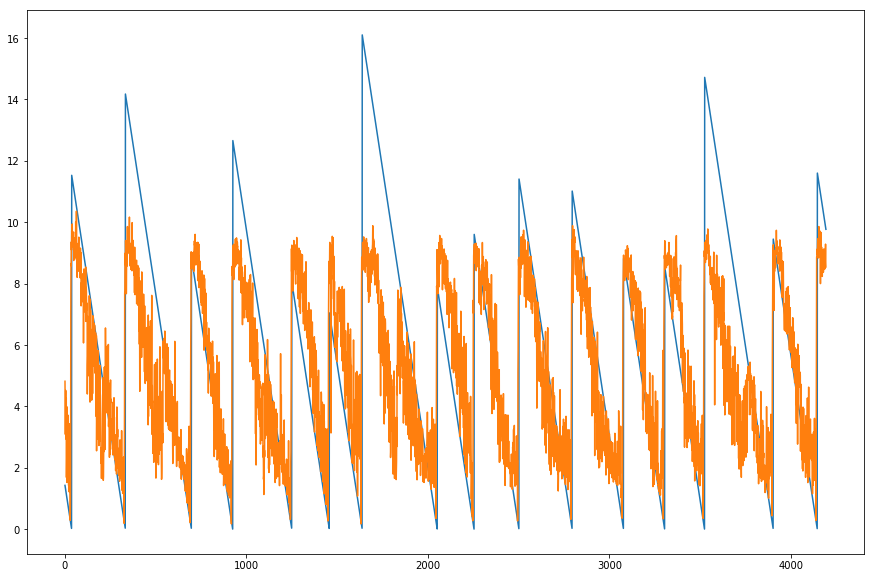

In [18]:
plt.figure(figsize=(15,10))
plt.plot(y_tr)
plt.plot(GPI(alldata[:X_tr.shape[0]]))

In [19]:
submission.time_to_failure = GPI(alldata[X_tr.shape[0]:]).values
submission.to_csv('gpsubmission.csv',index=True)
submission.head()

,time_to_failure
seg_id,
seg_00030f,3.163450301534621
seg_0012b5,5.122903492001674
seg_00184e,4.878316564580176
seg_003339,7.867255038555157
seg_0042cc,6.608135093974981
